In [4]:
!pip install feature-engine
!pip install category_encoders
!pip install catboost


# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from scipy.stats import boxcox, yeojohnson
from scipy.special import inv_boxcox
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, make_scorer, f1_score
from google.colab import files
from sklearn.preprocessing import MinMaxScaler


In [5]:
# Load dataset
url = "marketing_campaign.csv"
df = pd.read_csv(url)

In [6]:
# print 5 first observations to start getting familiar with the dataset
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04/09/2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08/03/2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21/08/2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10/02/2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19/01/2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [7]:
# print column types
df.dtypes

,0
ID,int64
Year_Birth,int64
Education,object
Marital_Status,object
Income,float64
Kidhome,int64
Teenhome,int64
Dt_Customer,object
Recency,int64
MntWines,int64


In [8]:
# Missing values
missing_values = df.isnull().sum()
print("Missing Values per Column:")
missing_values
# Βήμα 1: Εύρεση του πλήθους και του ποσοστού των missing τιμών
missing_count = df['Income'].isnull().sum()
total_count = len(df)
missing_percentage = (missing_count / total_count) * 100

print(f"Number of missing values: {missing_count}")
print(f"Percentage of missing values: {missing_percentage:.2f}%")

Missing Values per Column:
Number of missing values: 24
Percentage of missing values: 1.07%


In [9]:
import numpy as np

# Συνάρτηση που βρίσκει τα outliers μιας pandas Series
def find_outliers(series):
    # Αφαιρούμε NaN για τον υπολογισμό
    s = series.dropna()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    return s[(s < lower) | (s > upper)]

# 1. Βρες τις αριθμητικές στήλες στο train set
num_features = df.select_dtypes(include=['int64', 'float64']).columns

# 2. Εντοπισμός outliers ανά στήλη
outlier_info = {}
for col in num_features:
    out = find_outliers(df[col])
    if not out.empty:
        outlier_info[col] = out

# 3. Εκτύπωση αποτελεσμάτων
if not outlier_info:
    print("Δεν βρέθηκαν outliers σε καμία αριθμητική στήλη.")
else:
    for col, out in outlier_info.items():
        print(f"Στήλη: {col}")
        print(f"  • Outliers: {len(out)} τιμές")
        print(f"  • Τιμές: {np.unique(out.values)}\n")


Στήλη: Year_Birth
  • Outliers: 3 τιμές
  • Τιμές: [1893 1899 1900]

Στήλη: Income
  • Outliers: 8 τιμές
  • Τιμές: [153924. 156924. 157146. 157243. 157733. 160803. 162397. 666666.]

Στήλη: MntWines
  • Outliers: 35 τιμές
  • Τιμές: [1230 1239 1241 1245 1248 1252 1253 1259 1276 1279 1285 1288 1296 1298
 1302 1308 1311 1315 1324 1332 1349 1379 1394 1396 1449 1459 1462 1478
 1486 1492 1493]

Στήλη: MntFruits
  • Outliers: 227 τιμές
  • Τιμές: [ 82  83  84  85  86  87  88  89  90  91  92  93  96  97  98  99 100 101
 102 103 104 105 106 107 108 111 112 114 115 117 120 122 123 124 126 127
 129 130 131 132 133 134 137 138 140 142 143 144 147 148 149 151 152 153
 154 155 159 160 161 162 163 164 166 168 169 172 174 178 181 183 184 185
 189 190 193 194 197 199]

Στήλη: MntMeatProducts
  • Outliers: 175 τιμές
  • Τιμές: [ 558  559  560  561  562  565  567  568  569  570  572  573  575  586
  590  591  592  594  595  597  599  601  602  603  604  606  607  611
  612  613  614  617  622  625  629 

In [10]:
# Summary statistics for numerical features
print("Summary Statistics:")
df.describe()

Summary Statistics:


,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


In [11]:
print(df.describe().loc[['min', 'max']])


          ID  Year_Birth    Income  Kidhome  Teenhome  Recency  MntWines  \
min      0.0      1893.0    1730.0      0.0       0.0      0.0       0.0   
max  11191.0      1996.0  666666.0      2.0       2.0     99.0    1493.0   

     MntFruits  MntMeatProducts  MntFishProducts  ...  NumWebVisitsMonth  \
min        0.0              0.0              0.0  ...                0.0   
max      199.0           1725.0            259.0  ...               20.0   

     AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  \
min           0.0           0.0           0.0           0.0           0.0   
max           1.0           1.0           1.0           1.0           1.0   

     Complain  Z_CostContact  Z_Revenue  Response  
min       0.0            3.0       11.0       0.0  
max       1.0            3.0       11.0       1.0  

[2 rows x 26 columns]


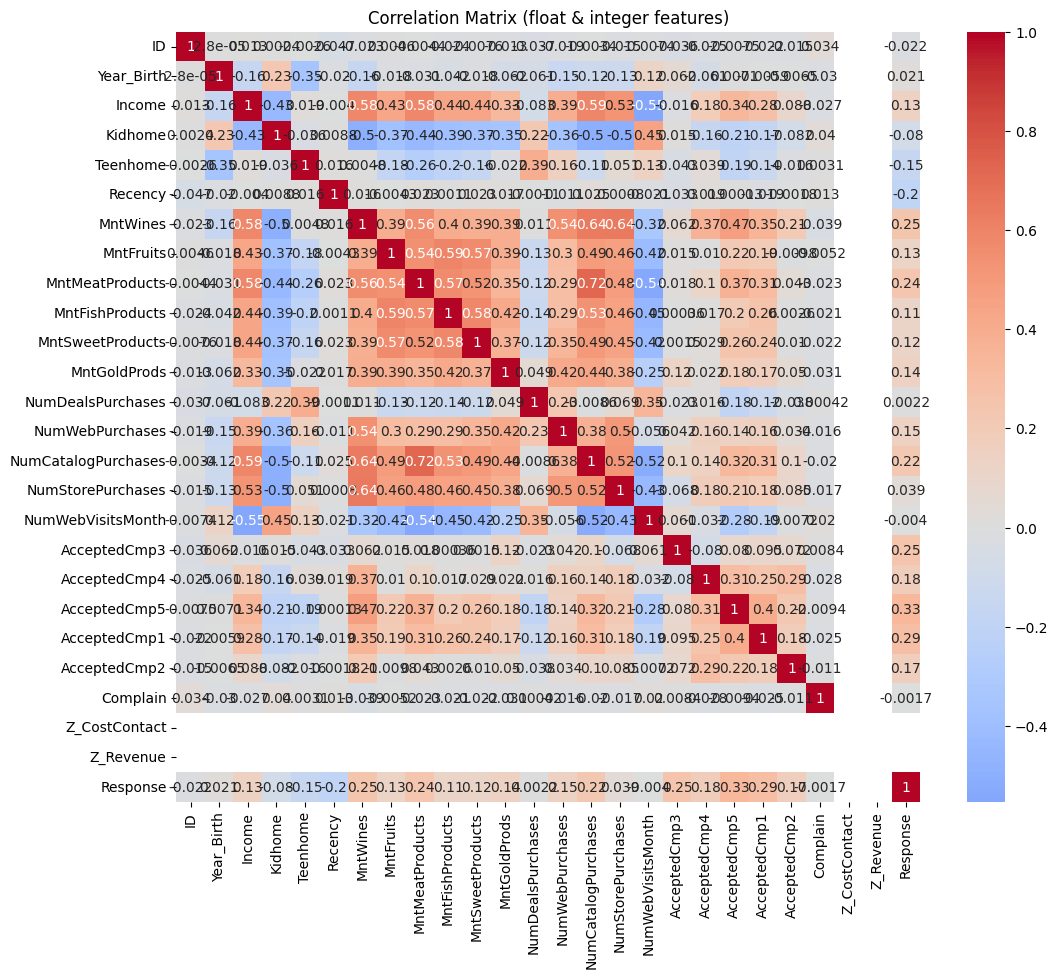

In [12]:
# 1. Φιλτράρεις μόνο τις αριθμητικές στήλες
num_cols = df.select_dtypes(include=[np.number]).columns
# num_corr = df.corr(numeric_only=True)

# 2. Υπολογίζεις τον πίνακα συσχέτισης μόνο για αυτές
corr_matrix = df[num_cols].corr(method='pearson')

# 3. Σχεδιάζεις το heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax)
ax.set_title("Correlation Matrix (float & integer features)")
plt.show()

<Axes: xlabel='Response'>

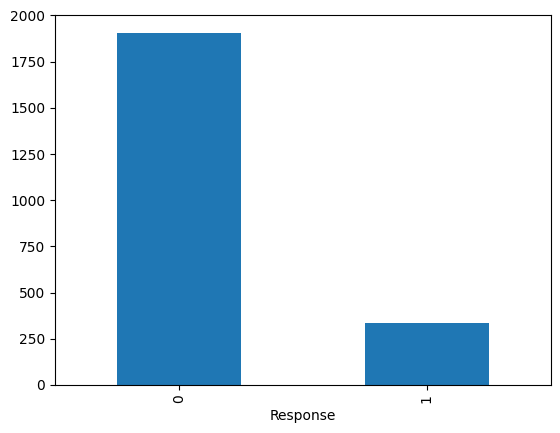

In [13]:
df['Response'].value_counts().plot(kind='bar')
#unbalanced

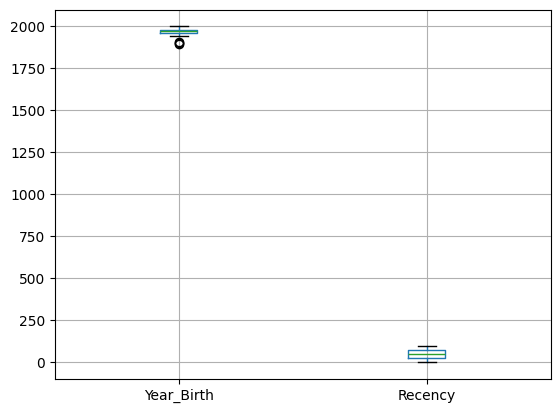

In [14]:
df[['Year_Birth','Recency']].boxplot()
plt.show()

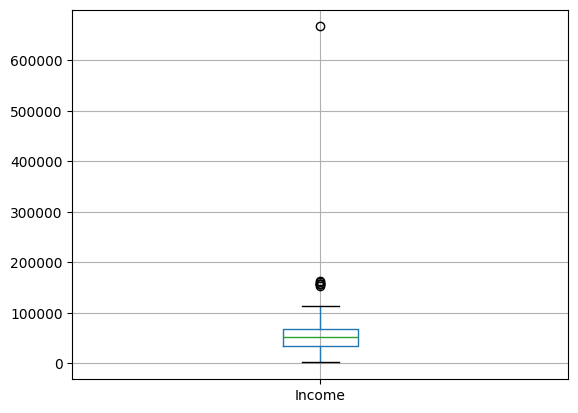

In [15]:
df[['Income']].boxplot()
plt.show()

In [16]:
# Βρίσκει τις στήλες που έχουν ακριβώς μία μοναδική τιμή
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
print("Οι στήλες με την ίδια τιμή σε κάθε γραμμή είναι:", constant_columns)


Οι στήλες με την ίδια τιμή σε κάθε γραμμή είναι: ['Z_CostContact', 'Z_Revenue']


In [17]:
df.drop(['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)


In [18]:
print(df['Year_Birth'].describe())

count    2240.000000
mean     1968.805804
std        11.984069
min      1893.000000
25%      1959.000000
50%      1970.000000
75%      1977.000000
max      1996.000000
Name: Year_Birth, dtype: float64


In [19]:
# Θέτουμε το όριο (threshold) ως 1902
threshold = 1902

# Φιλτράρουμε το DataFrame ώστε να κρατήσουμε μόνο τις γραμμές όπου το Year_Birth >= threshold
df = df[df['Year_Birth'] >= threshold]

# Έλεγχος αποτελεσμάτων: εμφάνιση του summary της στήλης Year_Birth
print(df['Year_Birth'].describe())

count    2237.000000
mean     1968.901654
std        11.701917
min      1940.000000
25%      1959.000000
50%      1970.000000
75%      1977.000000
max      1996.000000
Name: Year_Birth, dtype: float64


In [20]:
print(df['Income'].describe())

count      2213.000000
mean      52236.581563
std       25178.603047
min        1730.000000
25%       35246.000000
50%       51373.000000
75%       68487.000000
max      666666.000000
Name: Income, dtype: float64


Text(0, 0.5, 'frequency')

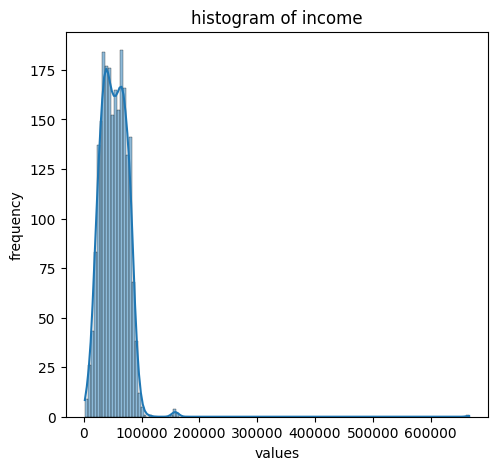

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Income'].dropna(), kde=True)
plt.title('histogram of income')
plt.xlabel('values')
plt.ylabel('frequency')

In [22]:
#df = df[df['Income'] != 666666.000000]
#print(df['Income'].describe())

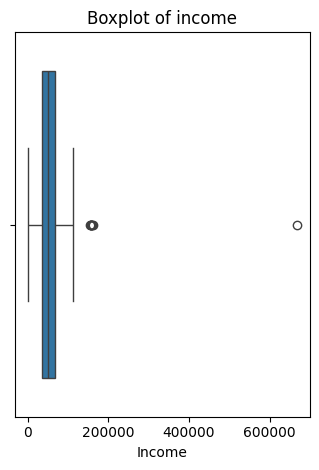

In [23]:
plt.subplot(1, 2, 2)
sns.boxplot(x=df['Income'])
plt.title('Boxplot of income')

plt.tight_layout()
plt.show()

In [24]:
# Get the unique values in the Education column
unique_values = df['Education'].unique()

# Get the number of unique values
num_unique = df['Education'].nunique()

print("Number of unique values in Education column:", num_unique)
print("Unique values:", unique_values)

Number of unique values in Education column: 5
Unique values: ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']


In [25]:
print("\nValue counts:")
print(df['Marital_Status'].value_counts())


Value counts:
Marital_Status
Married     864
Together    579
Single      479
Divorced    231
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64


In [26]:
# Ορισμός των σπάνιων τιμών που θέλουμε να συγχωνεύσουμε
rare_statuses = ["Alone", "Absurd", "YOLO"]

# Αντικατάσταση των τιμών στη στήλη "Marital_Status" με "Else"
df["Marital_Status"] = df["Marital_Status"].replace(rare_statuses, "Else")
# Έλεγχος των value counts μετά την αντικατάσταση
print(df["Marital_Status"].value_counts())

Marital_Status
Married     864
Together    579
Single      479
Divorced    231
Widow        77
Else          7
Name: count, dtype: int64


<ipython-input-27-3aa4d9b2445e>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  registrations = df.groupby(pd.Grouper(key='Dt_Customer', freq='M')).size()


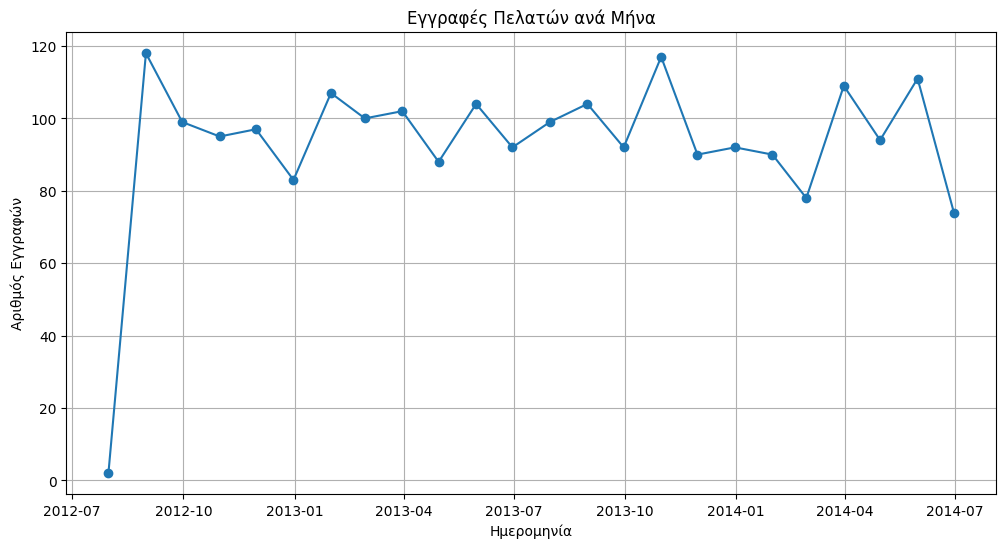

In [27]:
# Υποθέτουμε ότι το DataFrame σου ονομάζεται df και η στήλη Dt_Customer έχει τις ημερομηνίες σε μορφή 'dd/mm/yyyy'
# Μετατροπή της στήλης σε datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d/%m/%Y')

# Ομαδοποίηση των εγγραφών ανά μήνα και υπολογισμός του αριθμού εγγραφών
registrations = df.groupby(pd.Grouper(key='Dt_Customer', freq='M')).size()

# Δημιουργία line plot για την παρακολούθηση των εγγραφών με την πάροδο του χρόνου
plt.figure(figsize=(12, 6))
plt.plot(registrations.index, registrations.values, marker='o', linestyle='-')
plt.title('Εγγραφές Πελατών ανά Μήνα')
plt.xlabel('Ημερομηνία')
plt.ylabel('Αριθμός Εγγραφών')
plt.grid(True)
plt.show()

<ipython-input-28-27ce94df5e42>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  response_by_month = df.groupby(pd.Grouper(key='Dt_Customer', freq='M'))['Response'].mean()


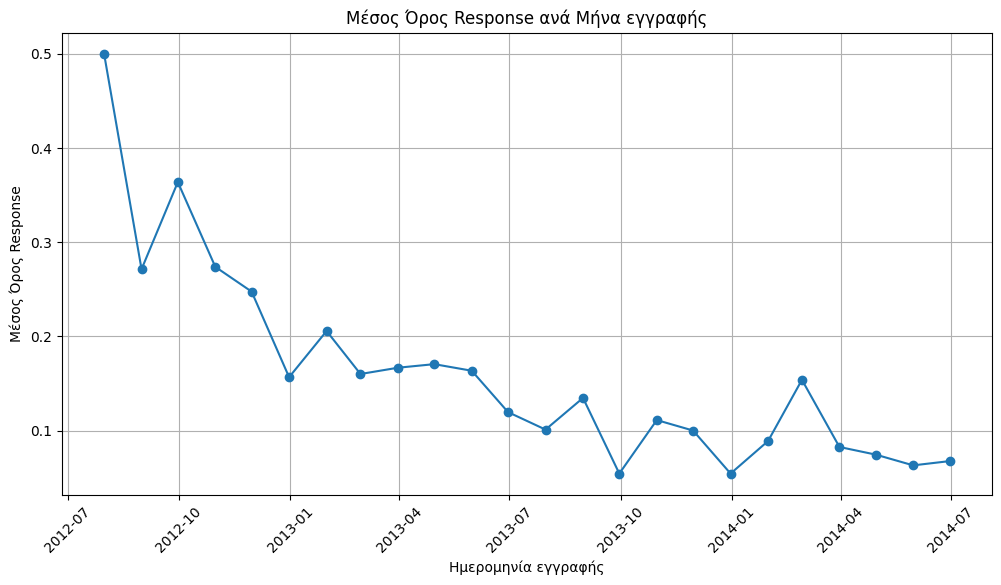

In [28]:
# Μετατροπή της στήλης Dt_Customer σε datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d/%m/%Y')

# Ομαδοποίηση των εγγραφών ανά μήνα και υπολογισμός του μέσου όρου της Response
response_by_month = df.groupby(pd.Grouper(key='Dt_Customer', freq='M'))['Response'].mean()

# Σχεδίαση γραφήματος (line plot)
plt.figure(figsize=(12, 6))
plt.plot(response_by_month.index, response_by_month.values, marker='o', linestyle='-')
plt.title('Μέσος Όρος Response ανά Μήνα εγγραφής')
plt.xlabel('Ημερομηνία εγγραφής')
plt.ylabel('Μέσος Όρος Response')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [29]:
# Mέγιστη ημερομηνία που υπάρχει στο dataset
reference_date = df['Dt_Customer'].max()

# Δημιουργία νέας στήλης που δείχνει πόσες μέρες έχουν περάσει από την εγγραφή ως την reference_date
df['days_from_registration'] = (reference_date - df['Dt_Customer']).dt.days

df['months_from_registration'] = df['days_from_registration'] / 30

print(df[['Dt_Customer', 'days_from_registration','months_from_registration']].head(10))


  Dt_Customer  days_from_registration  months_from_registration
0  2012-09-04                     663                 22.100000
1  2014-03-08                     113                  3.766667
2  2013-08-21                     312                 10.400000
3  2014-02-10                     139                  4.633333
4  2014-01-19                     161                  5.366667
5  2013-09-09                     293                  9.766667
6  2012-11-13                     593                 19.766667
7  2013-05-08                     417                 13.900000
8  2013-06-06                     388                 12.933333
9  2014-03-13                     108                  3.600000


In [30]:
df.drop(['Dt_Customer',  'days_from_registration'], axis=1, inplace=True)


In [31]:
# print column types
df.dtypes

,0
ID,int64
Year_Birth,int64
Education,object
Marital_Status,object
Income,float64
Kidhome,int64
Teenhome,int64
Recency,int64
MntWines,int64
MntFruits,int64


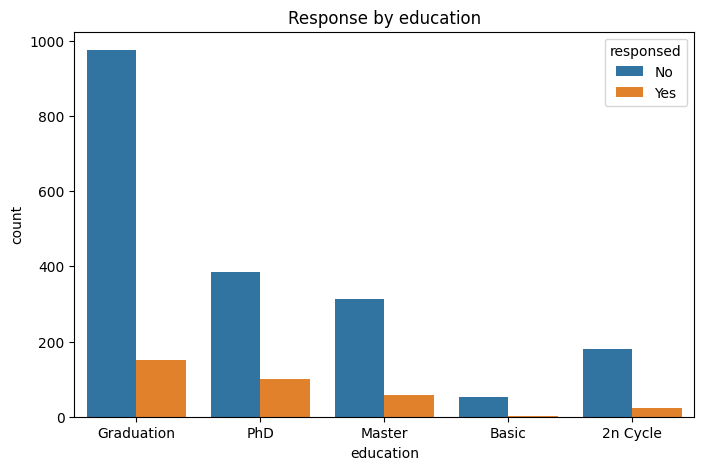

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(data=df, x='Education', hue='Response')
ax.set_title('Response by education')
ax.set_xlabel('education')
ax.set_ylabel('count')
ax.legend(title='responsed', loc='upper right', labels=['No', 'Yes'])

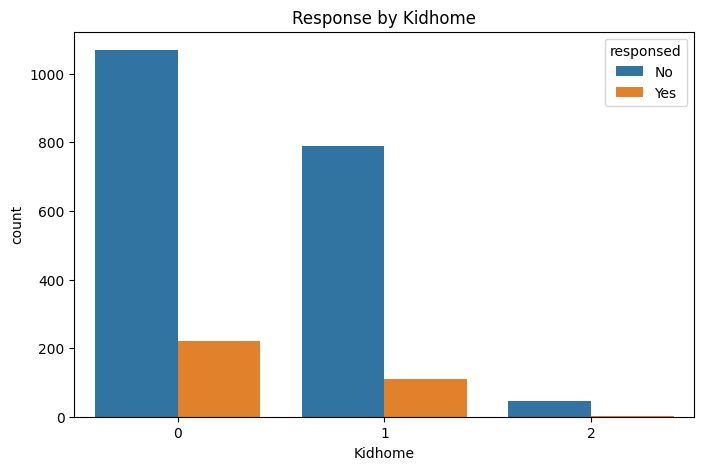

In [33]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(data=df, x='Kidhome', hue='Response')
ax.set_title('Response by Kidhome')
ax.set_xlabel('Kidhome')
ax.set_ylabel('count')
ax.legend(title='responsed', loc='upper right', labels=['No', 'Yes'])

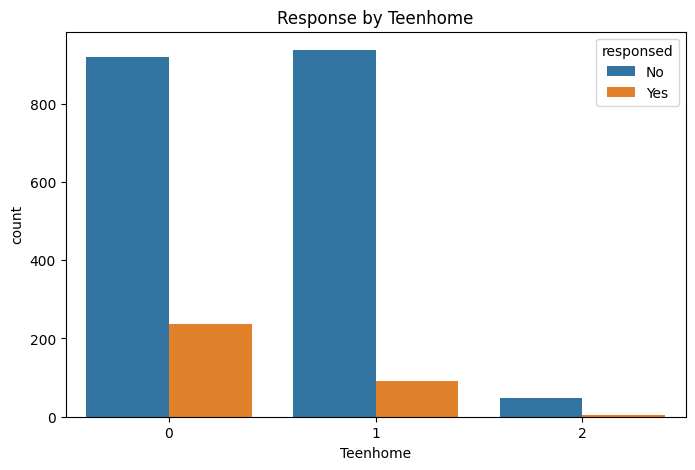

In [34]:
fig, ax = plt.subplots(figsize=(8, 5))#parapano aftoi p den exoun efibous apantisi ne
sns.countplot(data=df, x='Teenhome', hue='Response')
ax.set_title('Response by Teenhome')
ax.set_xlabel('Teenhome')
ax.set_ylabel('count')
ax.legend(title='responsed', loc='upper right', labels=['No', 'Yes'])

Text(0, 0.5, 'Frequency')

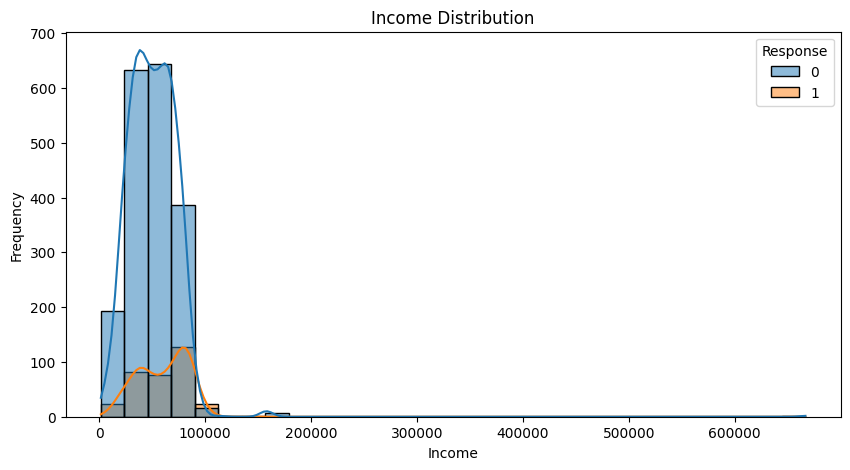

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df, x='Income', bins=30, kde=True,hue='Response')
ax.set_title('Income Distribution')
ax.set_xlabel('Income')
ax.set_ylabel('Frequency')

In [36]:
max_idx = df['Income'].idxmax()
print("Διαγράφεται η γραμμή:", max_idx, "με income =", df.loc[max_idx, 'Income'])
df.drop(index=max_idx, inplace=True)


Διαγράφεται η γραμμή: 2233 με income = 666666.0


Text(0, 0.5, 'Frequency')

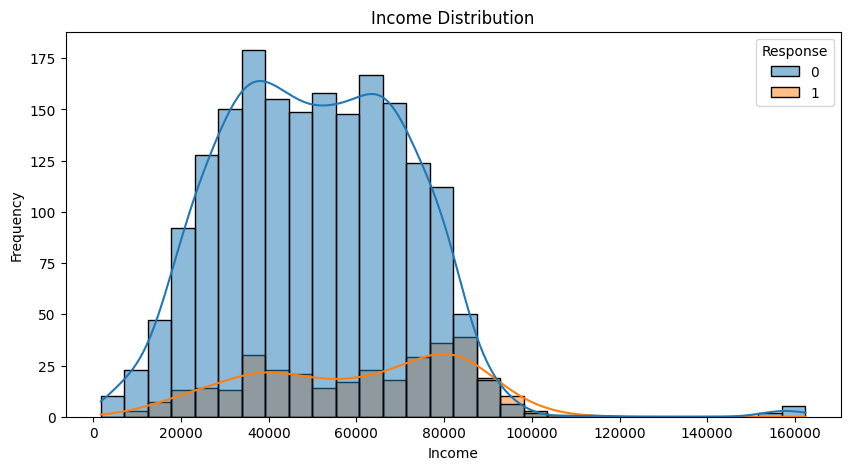

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df, x='Income', bins=30, kde=True,hue='Response')
ax.set_title('Income Distribution')
ax.set_xlabel('Income')
ax.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

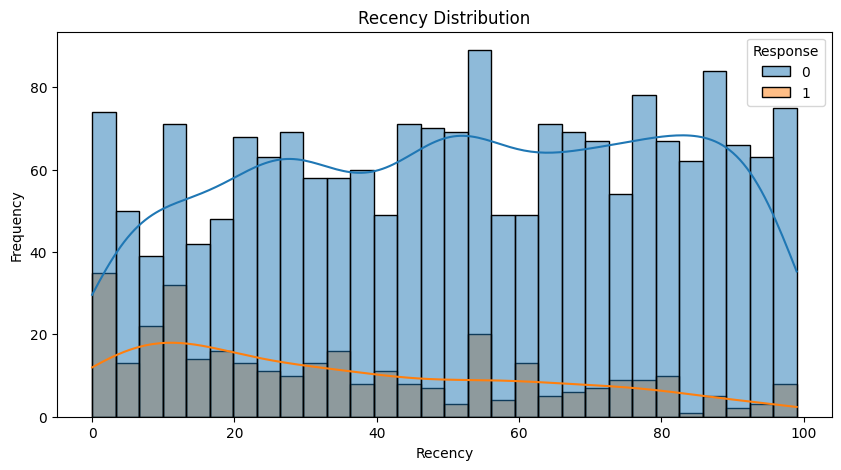

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df, x='Recency', bins=30, kde=True,hue='Response')
ax.set_title('Recency Distribution')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')

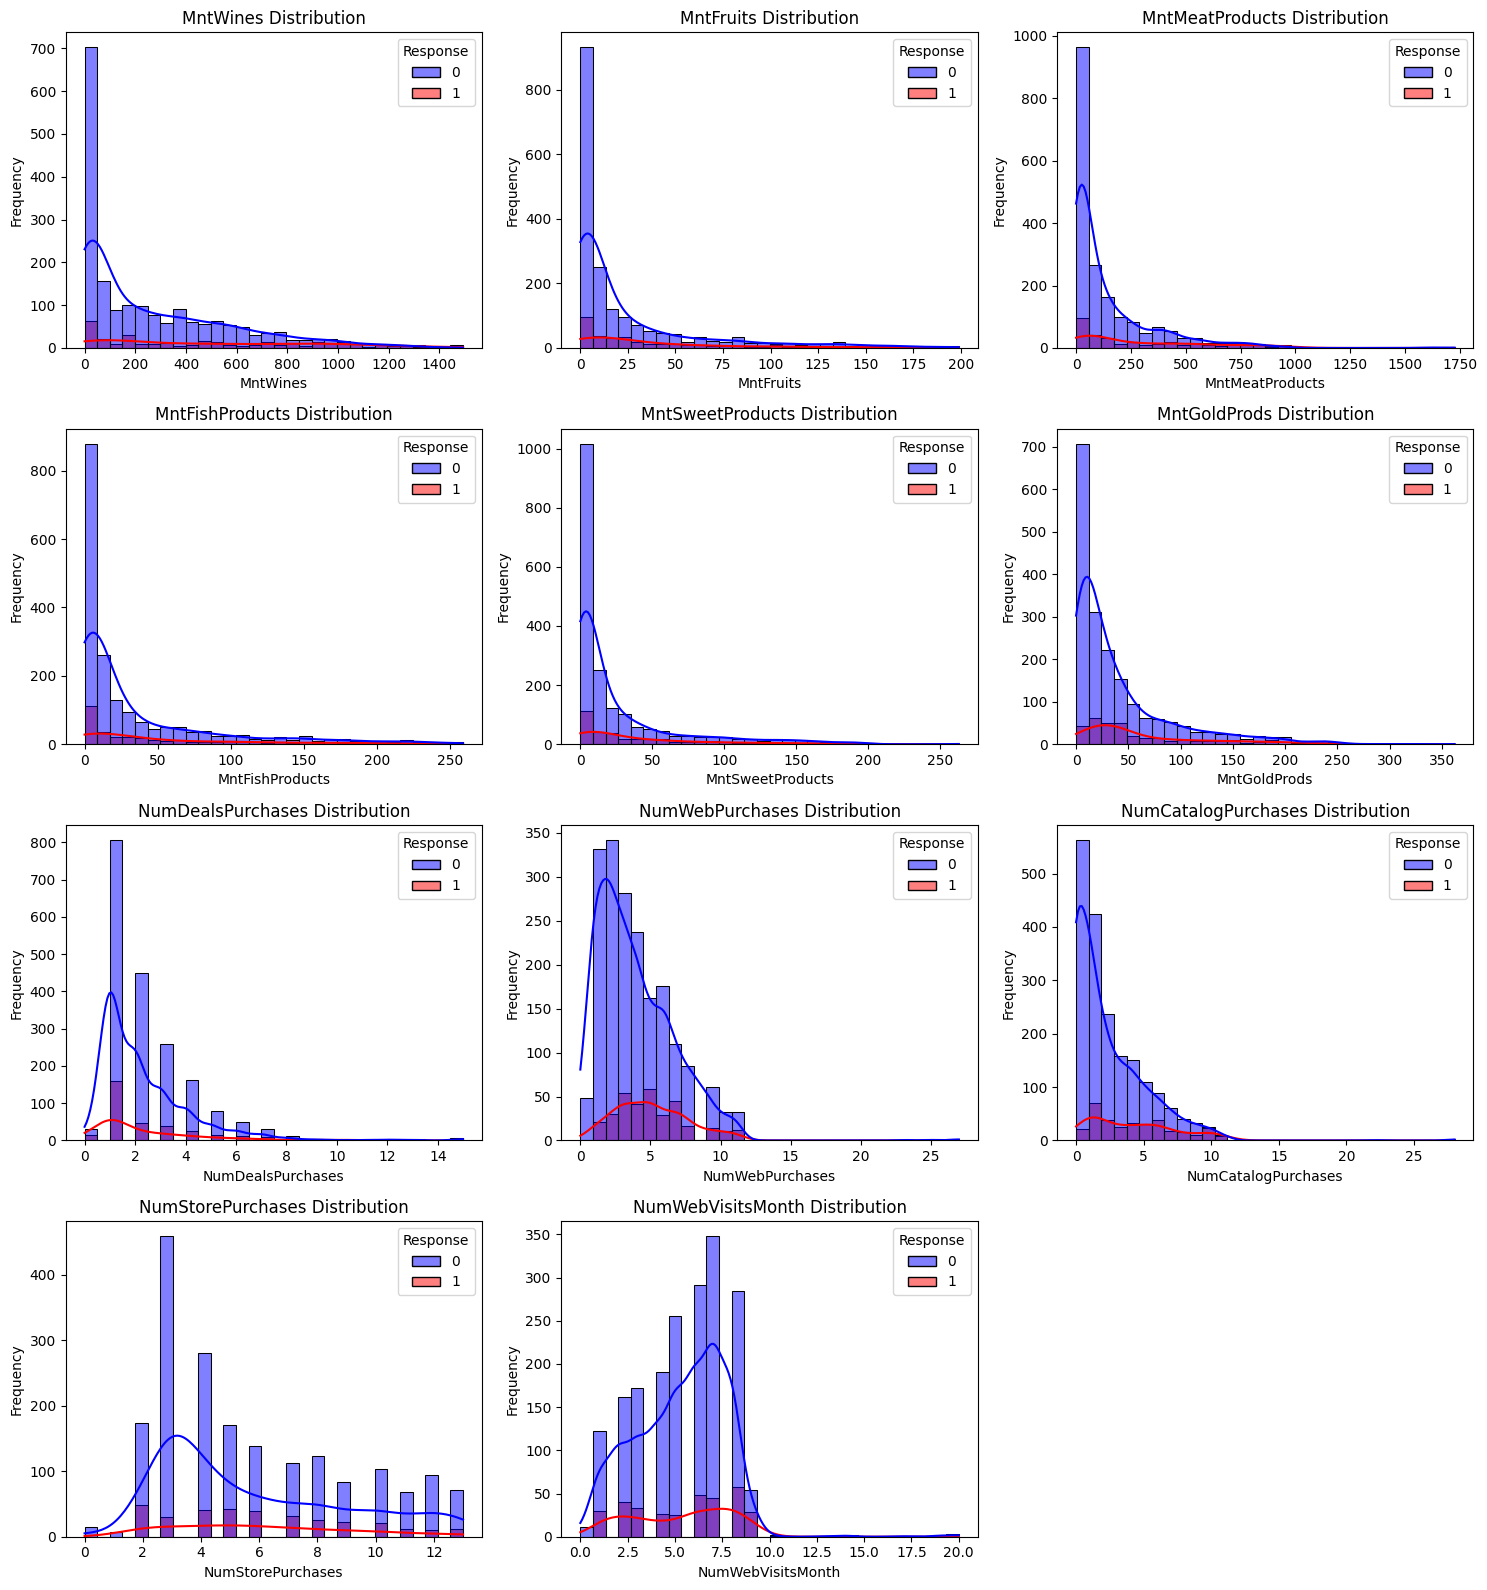

In [39]:
# Λίστα με τις μεταβλητές ενδιαφέροντος
features = [
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
    'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
    'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
    'NumWebVisitsMonth'
]

# Ορισμός παραμέτρων για τα subplots (π.χ. 3 στήλες)
n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols  # υπολογισμός γραμμών

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # Για ευκολότερη επανάληψη

# Loop για κάθε feature
for i, feature in enumerate(features):
    sns.histplot(
        data=df, x=feature, bins=30, kde=True,
        hue='Response', ax=axes[i], palette=['blue', 'red']
    )
    axes[i].set_title(f'{feature} Distribution')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Αφαίρεση επιπλέον subplots αν υπάρχουν
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

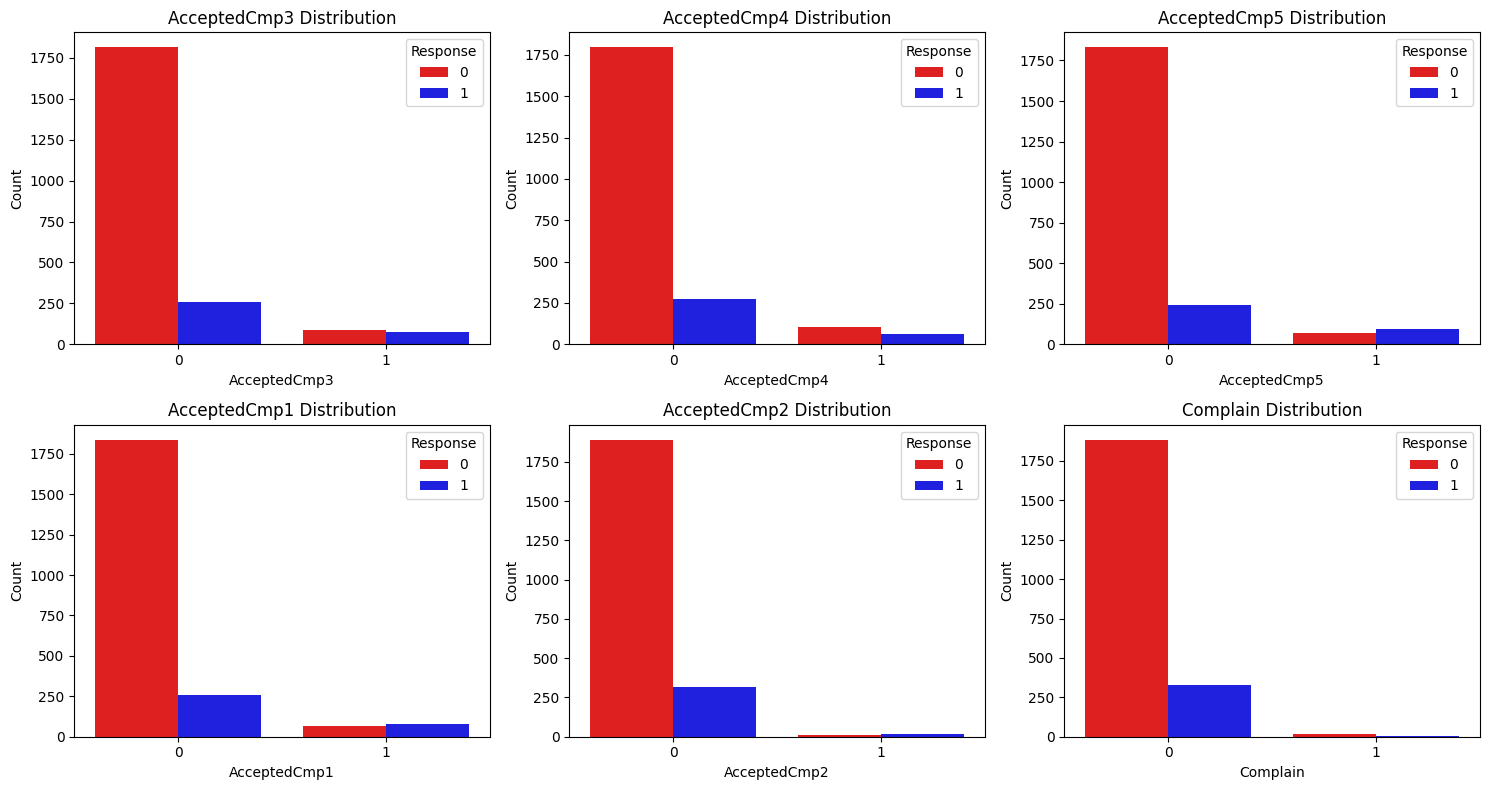

In [40]:
# Λίστα με τις δυαδικές μεταβλητές
features_binary = [
    'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
    'AcceptedCmp1', 'AcceptedCmp2', 'Complain'
]

# Ορισμός παραμέτρων για τα subplots: π.χ. 3 στήλες
n_cols = 3
n_rows = (len(features_binary) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()
# Loop για κάθε feature
for i, feature in enumerate(features_binary):
    sns.countplot(data=df, x=feature, hue='Response', ax=axes[i], palette=['red', 'blue'])
    axes[i].set_title(f'{feature} Distribution')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')

# Κατάργηση επιπλέον subplots (αν υπάρχουν)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Frequency')

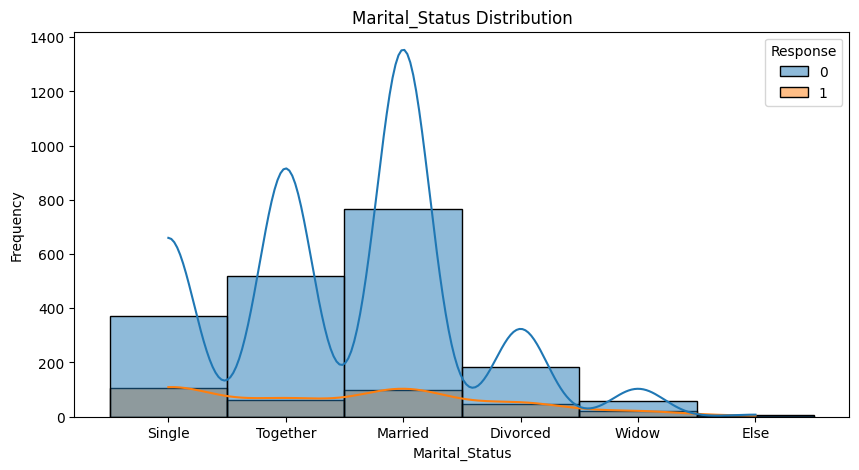

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df, x='Marital_Status',  kde=True,hue='Response')
ax.set_title('Marital_Status Distribution')
ax.set_xlabel('Marital_Status')
ax.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

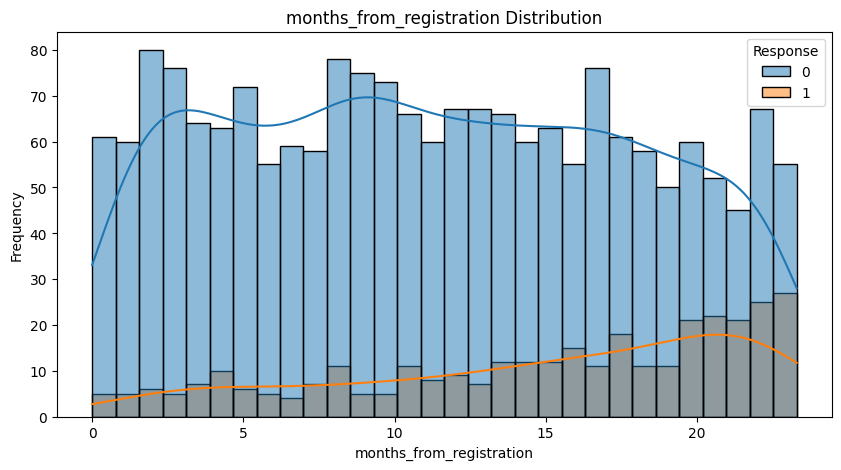

In [42]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df, x='months_from_registration', bins=30, kde=True,hue='Response')
ax.set_title('months_from_registration Distribution')
ax.set_xlabel('months_from_registration')
ax.set_ylabel('Frequency')

In [43]:
print(df['months_from_registration'].describe())


count    2236.000000
mean       11.792442
std         6.739385
min         0.000000
25%         6.025000
50%        11.866667
75%        17.633333
max        23.300000
Name: months_from_registration, dtype: float64


In [44]:
skewness = df.select_dtypes(include=['int64', 'float64']).skew()
print(skewness.sort_values(ascending=False))


Complain                    10.438160
AcceptedCmp2                 8.464221
AcceptedCmp1                 3.551553
AcceptedCmp5                 3.300787
AcceptedCmp3                 3.287997
AcceptedCmp4                 3.237901
NumDealsPurchases            2.418461
MntSweetProducts             2.135674
MntFruits                    2.104241
MntMeatProducts              2.085282
Response                     1.968607
MntFishProducts              1.919970
MntGoldProds                 1.885136
NumCatalogPurchases          1.881437
NumWebPurchases              1.381134
MntWines                     1.176036
NumStorePurchases            0.700138
Kidhome                      0.636284
Teenhome                     0.405903
Income                       0.348028
NumWebVisitsMonth            0.207904
ID                           0.041070
Recency                     -0.004299
months_from_registration    -0.016397
Year_Birth                  -0.092495
dtype: float64


In [45]:
df.drop(['ID', 'Year_Birth'], axis=1, inplace=True)

In [46]:
# @title Split dataset
# Split features and target
X = df.drop('Response', axis=1)
y = df['Response']

In [47]:
# Split the data into training and test sets before scaling, encoding to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# @title Data Preprocessing and hyperparameter tuning


In [49]:
# @title Dataset v1


In [50]:
X_train_V_1 = X_train.copy()
X_test_V_1 = X_test.copy()

In [51]:
# Identify numerical and categorical features
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns
print(cat_features)


Index(['Education', 'Marital_Status'], dtype='object')


In [52]:
# Apply simple imputer with median strategy on numerical features | Income has outliers
si1 = SimpleImputer(strategy='median')
# fit (train) imputer on the training dataset
si1.fit(X_train_V_1[num_features])
# apply imputation on both training and test datasets
X_train_V_1[num_features] = si1.transform(X_train_V_1[num_features])
X_test_V_1[num_features] = si1.transform(X_test_V_1[num_features])


In [53]:

# Apply one hot encoding on categorical features
onehot_encoder = OneHotEncoder(
    use_cat_names=True,       # τα dummy columns θα έχουν ως suffix το όνομα της τιμής
    handle_unknown='value',   # οι άγνωστες κατηγορίες στο test θα γίνουν 0
    return_df=True
)

new_cols_train = onehot_encoder.fit_transform(X_train[['Marital_Status']])
# Concatenate the original DataFrame with the encoded DataFrame
X_train_V_1 = pd.concat([X_train_V_1, new_cols_train], axis=1)
# Drop the original categorical column if you no longer need it
X_train_V_1 = X_train_V_1.drop(columns=['Marital_Status'])

new_cols_test = onehot_encoder.transform(X_test[['Marital_Status']])
X_test_V_1 = pd.concat([X_test_V_1, new_cols_test], axis=1)
X_test_V_1 = X_test_V_1.drop(columns=['Marital_Status'])


In [54]:
edu_mapping = {
    'Basic':       1,
    '2n Cycle':    2,
    'Graduation':  3,
    'Master':      4,
    'PhD':         5,
}
# Apply ordinal encoding on categorical features
ordinal_encoder = OrdinalEncoder(return_df=True)

X_train_V_1[['Education']] = ordinal_encoder.fit_transform(X_train_V_1[['Education']])
X_test_V_1[['Education']] = ordinal_encoder.transform(X_test_V_1[['Education']])

In [55]:
# @title Dataset V2


In [56]:
X_train_V_2 = X_train.copy()
X_test_V_2 = X_test.copy()

In [57]:
# Identify numerical and categorical features
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns
print(cat_features)


Index(['Education', 'Marital_Status'], dtype='object')


In [58]:
# O mean itan kaliteros sinexizoume me mean
si1 = SimpleImputer(strategy='mean')
# fit (train) imputer on the training dataset
si1.fit(X_train_V_2[num_features])
# apply imputation on both training and test datasets
X_train_V_2[num_features] = si1.transform(X_train_V_2[num_features])
X_test_V_2[num_features] = si1.transform(X_test_V_2[num_features])


In [59]:

# Apply one hot encoding on categorical features
onehot_encoder = OneHotEncoder(
    use_cat_names=True,       # τα dummy columns θα έχουν ως suffix το όνομα της τιμής
    handle_unknown='value',   # οι άγνωστες κατηγορίες στο test θα γίνουν 0
    return_df=True
)

new_cols_train = onehot_encoder.fit_transform(X_train[['Marital_Status']])
# Concatenate the original DataFrame with the encoded DataFrame
X_train_V_2 = pd.concat([X_train_V_2, new_cols_train], axis=1)
# Drop the original categorical column if you no longer need it
X_train_V_2 = X_train_V_2.drop(columns=['Marital_Status'])

new_cols_test = onehot_encoder.transform(X_test[['Marital_Status']])
X_test_V_2 = pd.concat([X_test_V_2, new_cols_test], axis=1)
X_test_V_2 = X_test_V_2.drop(columns=['Marital_Status'])


In [60]:
edu_mapping = {
    'Basic':       1,
    '2n Cycle':    2,
    'Graduation':  3,
    'Master':      4,
    'PhD':         5,
}
# Apply ordinal encoding on categorical features
ordinal_encoder = OrdinalEncoder(return_df=True)

X_train_V_2[['Education']] = ordinal_encoder.fit_transform(X_train_V_2[['Education']])
X_test_V_2[['Education']] = ordinal_encoder.transform(X_test_V_2[['Education']])

In [61]:
# @title Dataset v3


In [62]:
X_train_V_3 = X_train.copy()
X_test_V_3 = X_test.copy()

In [63]:
# Identify numerical and categorical features
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns
print(cat_features)


Index(['Education', 'Marital_Status'], dtype='object')


In [64]:
# Apply simple imputer with median strategy on numerical features | Income has outliers
si1 = SimpleImputer(strategy='mean')
# fit (train) imputer on the training dataset
si1.fit(X_train_V_3[num_features])
# apply imputation on both training and test datasets
X_train_V_3[num_features] = si1.transform(X_train_V_3[num_features])
X_test_V_3[num_features] = si1.transform(X_test_V_3[num_features])


In [65]:
#EDUCATION ME ORDINAL ENCODING KALITERO
# Apply one hot encoding on categorical features
onehot_encoder = OneHotEncoder(
    use_cat_names=True,       # τα dummy columns θα έχουν ως suffix το όνομα της τιμής
    handle_unknown='value',   # οι άγνωστες κατηγορίες στο test θα γίνουν 0
    return_df=True
)

new_cols_train = onehot_encoder.fit_transform(X_train[['Marital_Status','Education']])
# Concatenate the original DataFrame with the encoded DataFrame
X_train_V_3 = pd.concat([X_train_V_3, new_cols_train], axis=1)
# Drop the original categorical column if you no longer need it
X_train_V_3 = X_train_V_3.drop(columns=['Marital_Status','Education'])

new_cols_test = onehot_encoder.transform(X_test[['Marital_Status','Education']])
X_test_V_3 = pd.concat([X_test_V_3, new_cols_test], axis=1)
X_test_V_3 = X_test_V_3.drop(columns=['Marital_Status','Education'])


In [66]:
# @title Dataset v3.1


In [67]:
X_train_V_3_1 = X_train.copy()
X_test_V_3_1 = X_test.copy()

In [68]:
# Identify numerical and categorical features
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns
print(cat_features)


Index(['Education', 'Marital_Status'], dtype='object')


In [69]:
# Apply simple imputer with median strategy on numerical features | Income has outliers
si1 = SimpleImputer(strategy='median')
# fit (train) imputer on the training dataset
si1.fit(X_train_V_3_1[num_features])
# apply imputation on both training and test datasets
X_train_V_3_1[num_features] = si1.transform(X_train_V_3_1[num_features])
X_test_V_3_1[num_features] = si1.transform(X_test_V_3_1[num_features])


In [70]:
#EDUCATION ME ORDINAL ENCODING KALITERO
# Apply one hot encoding on categorical features
onehot_encoder = OneHotEncoder(
    use_cat_names=True,       # τα dummy columns θα έχουν ως suffix το όνομα της τιμής
    handle_unknown='value',   # οι άγνωστες κατηγορίες στο test θα γίνουν 0
    return_df=True
)

new_cols_train = onehot_encoder.fit_transform(X_train[['Marital_Status','Education']])
# Concatenate the original DataFrame with the encoded DataFrame
X_train_V_3_1 = pd.concat([X_train_V_3_1, new_cols_train], axis=1)

X_train_V_3_1 = X_train_V_3_1.drop(columns=['Marital_Status','Education'])

new_cols_test = onehot_encoder.transform(X_test[['Marital_Status','Education']])
X_test_V_3_1 = pd.concat([X_test_V_3_1, new_cols_test], axis=1)
X_test_V_3_1 = X_test_V_3_1.drop(columns=['Marital_Status','Education'])


In [71]:
from feature_engine.selection import DropCorrelatedFeatures
corr_sel = DropCorrelatedFeatures(
    variables=None,      # None = όλες οι numeric στήλες
    method="pearson",
    threshold=0.80
)

# 3) fit στο train
corr_sel.fit(X_train_V_3_1)

# 4) transform σε train & test
X_train_V_3_1 = corr_sel.transform(X_train_V_3_1)
X_test_V_3_1  = corr_sel.transform(X_test_V_3_1)

dropped = corr_sel.features_to_drop_
kept    = [c for c in X_train_V_3_1.columns if c not in dropped]

print("Dropped columns:", dropped)
print("Kept columns:   ", kept)

Dropped columns: []
Kept columns:    ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'months_from_registration', 'Marital_Status_Single', 'Marital_Status_Married', 'Marital_Status_Divorced', 'Marital_Status_Together', 'Marital_Status_Widow', 'Marital_Status_Else', 'Education_Graduation', 'Education_2n Cycle', 'Education_PhD', 'Education_Master', 'Education_Basic']


In [72]:
# @title Dataset v4


In [73]:
X_train_V_4 = X_train_V_3_1.copy()
X_test_V_4 = X_test_V_3_1.copy()

In [74]:
#robust MntWines MntFruits MntMeatProducts MntFishProducts MntSweetProducts Income
#johnson for unskewing

transformer = PowerTransformer(method='yeo-johnson')#standardize=True
features_to_scale = ['NumDealsPurchases'
,'MntMeatProducts','MntFishProducts','MntGoldProds','NumCatalogPurchases'
,'NumWebPurchases','NumStorePurchases','NumWebVisitsMonth','Recency','months_from_registration','MntWines', 'MntFruits','MntSweetProducts', 'Income']


X_train_V_4[features_to_scale] = transformer.fit_transform(X_train_V_4[features_to_scale])  # Fit and transform training data (Age and Fare columns only)
X_test_V_4[features_to_scale] = transformer.transform(X_test_V_4[features_to_scale])  # Transform test data
print(X_train_V_4[features_to_scale].describe())


       NumDealsPurchases  MntMeatProducts  MntFishProducts  MntGoldProds  \
count       1.788000e+03     1.788000e+03     1.788000e+03  1.788000e+03   
mean        1.549842e-16     1.192186e-17     9.636835e-17 -5.464185e-17   
std         1.000280e+00     1.000280e+00     1.000280e+00  1.000280e+00   
min        -3.046243e+00    -2.510353e+00    -1.509206e+00 -2.139064e+00   
25%        -8.290048e-01    -8.422453e-01    -7.017537e-01 -7.064480e-01   
50%         1.542436e-01     4.376544e-02     8.447247e-04  4.428131e-02   
75%         7.407381e-01     8.263083e-01     8.345996e-01  6.861221e-01   
max         2.638866e+00     2.246969e+00     1.852967e+00  2.487522e+00   

       NumCatalogPurchases  NumWebPurchases  NumStorePurchases  \
count         1.788000e+03     1.788000e+03       1.788000e+03   
mean         -4.172650e-17     1.231925e-16       6.407999e-17   
std           1.000280e+00     1.000280e+00       1.000280e+00   
min          -1.340966e+00    -2.372542e+00      -3

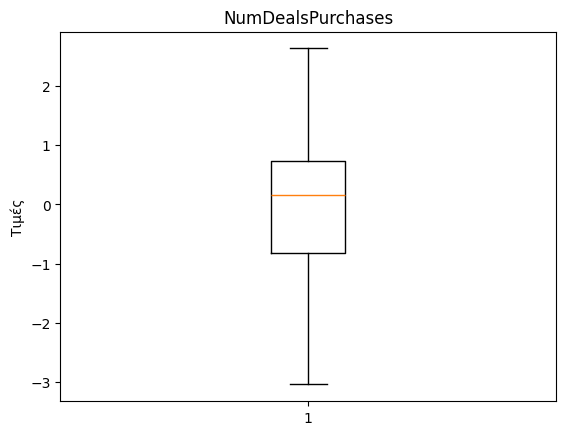

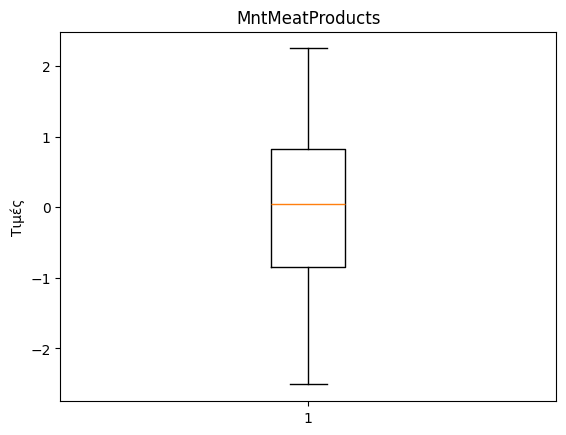

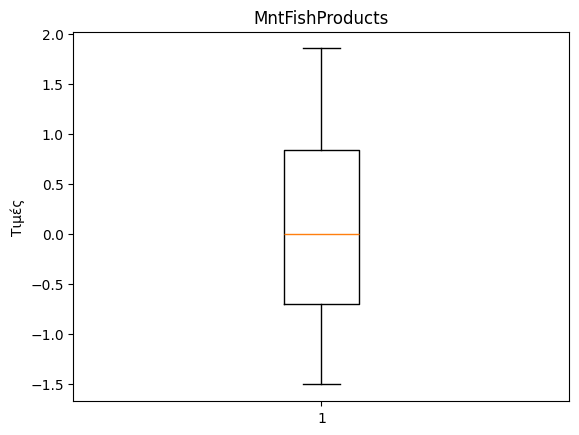

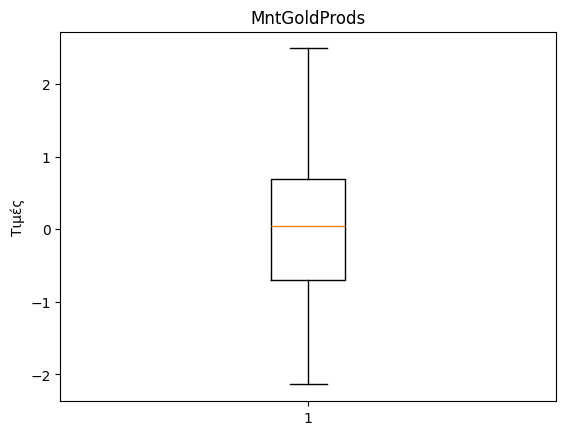

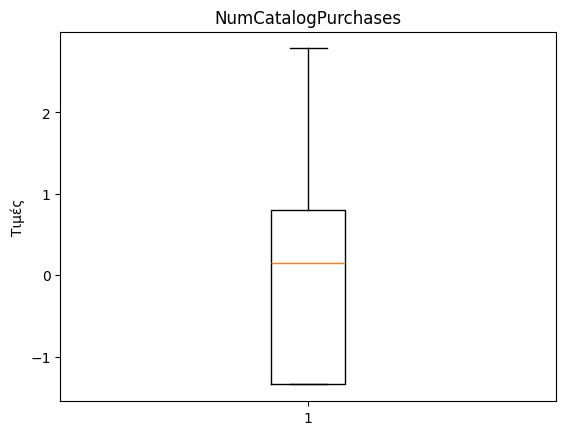

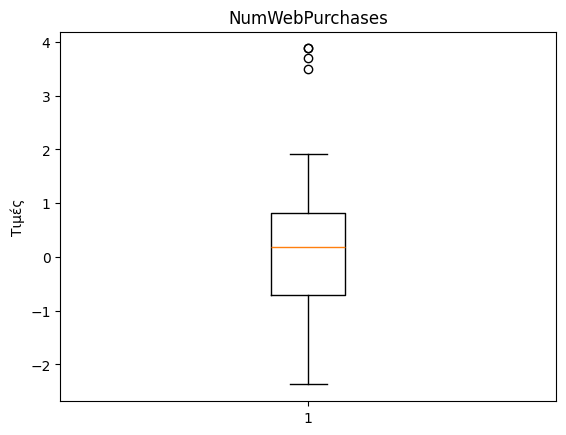

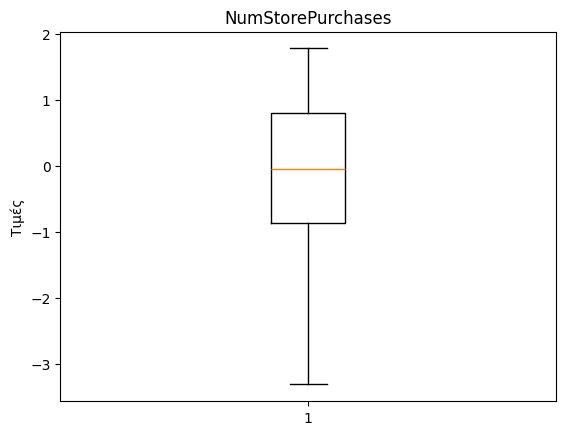

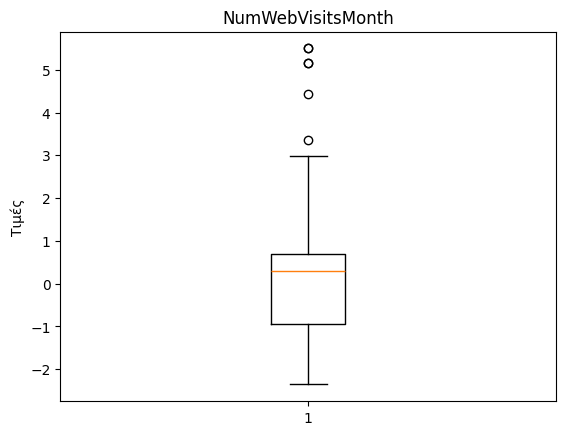

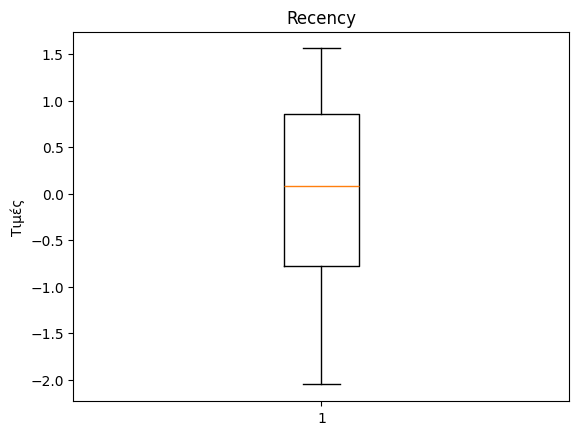

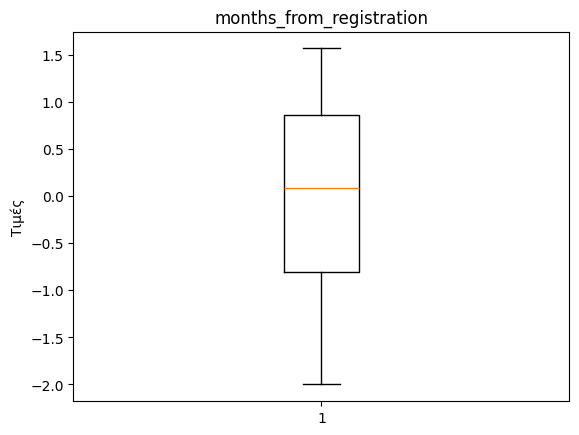

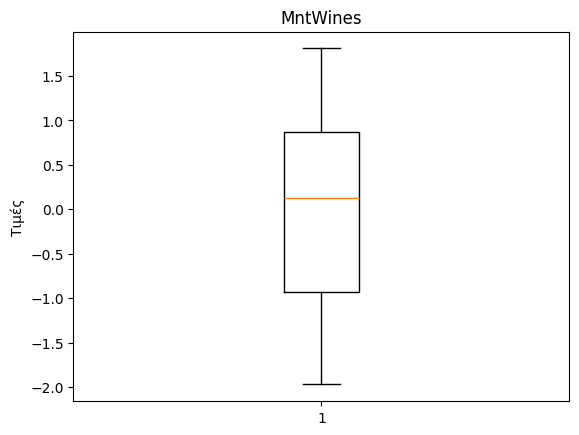

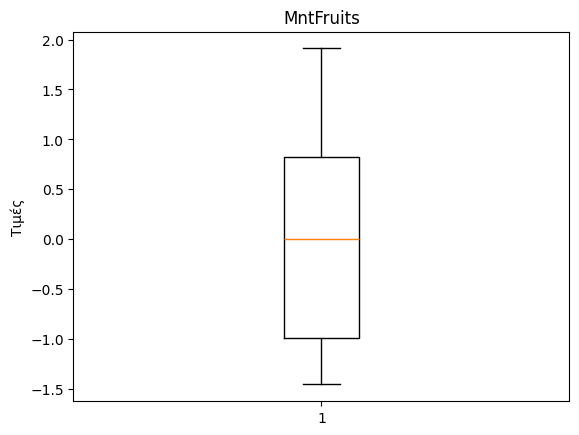

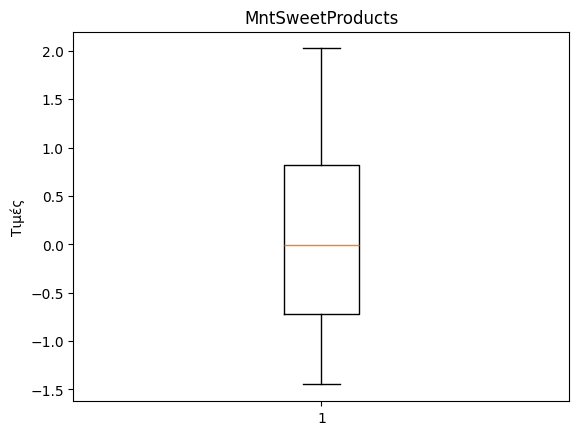

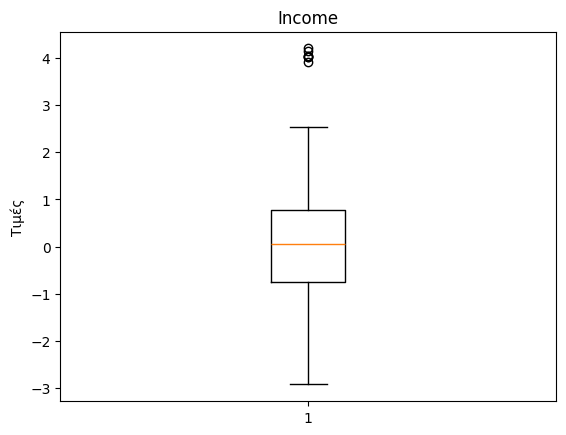

In [75]:
import matplotlib.pyplot as plt

features = [
    'NumDealsPurchases', 'MntMeatProducts', 'MntFishProducts', 'MntGoldProds',
    'NumCatalogPurchases', 'NumWebPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
    'Recency', 'months_from_registration', 'MntWines', 'MntFruits',
    'MntSweetProducts', 'Income'
]

df1 = X_train_V_4

for feat in features:
    plt.figure()
    plt.boxplot(df1[feat].dropna())
    plt.title(feat)
    plt.ylabel('Τιμές')
    plt.show()


In [76]:
for col in df1.columns:
    print(f"--- {col} ---")
    print(df1[col].describe())
    print()

--- Income ---
count    1.788000e+03
mean    -2.225413e-16
std      1.000280e+00
min     -2.918364e+00
25%     -7.425936e-01
50%      5.084929e-02
75%      7.738697e-01
max      4.197014e+00
Name: Income, dtype: float64

--- Kidhome ---
count    1788.000000
mean        0.441275
std         0.537791
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: Kidhome, dtype: float64

--- Teenhome ---
count    1788.000000
mean        0.512864
std         0.549051
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: Teenhome, dtype: float64

--- Recency ---
count    1.788000e+03
mean     1.361079e-16
std      1.000280e+00
min     -2.050828e+00
25%     -7.742334e-01
50%      8.167063e-02
75%      8.567138e-01
max      1.562642e+00
Name: Recency, dtype: float64

--- MntWines ---
count    1.788000e+03
mean    -1.900046e-16
std      1.000280e+00
min     -1.970541e+00
25%     -9.294719e-

In [77]:
# @title Dataset v4.1
#Να αποδειξω οτι με scaling o v3 ειναι καλυτερο απο v2

In [78]:
X_train_V_4_1 = X_train_V_2.copy()
X_test_V_4_1 = X_test_V_2.copy()

In [79]:
#robust MntWines MntFruits MntMeatProducts MntFishProducts MntSweetProducts Income
#johnson for unskewing

transformer = PowerTransformer(method='yeo-johnson',standardize=True)#standardize=True
features_to_scale = ['NumDealsPurchases','Education'
,'MntMeatProducts','MntFishProducts','MntGoldProds','NumCatalogPurchases'
,'NumWebPurchases','NumStorePurchases','NumWebVisitsMonth','Recency','months_from_registration','MntWines', 'MntFruits','MntSweetProducts', 'Income']


X_train_V_4_1[features_to_scale] = transformer.fit_transform(X_train_V_4_1[features_to_scale])  # Fit and transform training data (Age and Fare columns only)
X_test_V_4_1[features_to_scale] = transformer.transform(X_test_V_4_1[features_to_scale])  # Transform test data


In [80]:
# @title Dataset v5
 # ΔΕΝ ΧΡΗΣΗΜΟΠΟΙΗΘΗΚΕ BOXCOX ΛΩΓΟ ΜΗΔΕΝΙΚΩΝ ΤΙΜΩΝ
X_train_V_5 = X_train_V_3_1.copy()
X_test_V_5 = X_test_V_3_1.copy()

In [81]:
rs = RobustScaler()
features_to_scale = ['NumDealsPurchases'
,'MntMeatProducts','MntFishProducts','MntGoldProds','NumCatalogPurchases'
,'NumWebPurchases','NumStorePurchases','NumWebVisitsMonth','Recency','months_from_registration','MntWines', 'MntFruits', 'MntSweetProducts', 'Income']
rs.fit(X_train_V_5[features_to_scale])
X_train_V_5[features_to_scale] = rs.transform(X_train_V_5[features_to_scale])
X_test_V_5[features_to_scale] = rs.transform(X_test_V_5[features_to_scale])

In [82]:
# @title Dataset v5.1


In [83]:
X_train_V_5_1 = X_train_V_2.copy()
X_test_V_5_1 = X_test_V_2.copy()

In [84]:
rs = RobustScaler()
features_to_scale = ['NumDealsPurchases'
,'MntMeatProducts','MntFishProducts','MntGoldProds','NumCatalogPurchases'
,'NumWebPurchases','NumStorePurchases','NumWebVisitsMonth','Recency','months_from_registration','MntWines', 'MntFruits', 'MntSweetProducts', 'Income']
rs.fit(X_train_V_5_1[features_to_scale])
X_train_V_5_1[features_to_scale] = rs.transform(X_train_V_5_1[features_to_scale])
X_test_V_5_1[features_to_scale] = rs.transform(X_test_V_5_1[features_to_scale])

In [85]:
# @title Dataset v6
X_train_V_6 = X_train_V_3_1.copy()
X_test_V_6 = X_test_V_3_1.copy()

In [86]:
rs = RobustScaler()
features_to_scale = ['NumDealsPurchases'
,'MntMeatProducts','MntFishProducts','MntGoldProds','NumCatalogPurchases'
,'NumWebPurchases','MntWines', 'MntFruits', 'MntSweetProducts', 'Income']
rs.fit(X_train_V_6[features_to_scale])
X_train_V_6[features_to_scale] = rs.transform(X_train_V_6[features_to_scale])
X_test_V_6[features_to_scale] = rs.transform(X_test_V_6[features_to_scale])

In [87]:
# 4. Δημιουργία του scaler
scaler = StandardScaler()
features_to_scale = ['NumStorePurchases','NumWebVisitsMonth','Recency','months_from_registration']#education

# 5. Fit μόνο στο train set
scaler.fit(X_train_V_6[features_to_scale])


X_train_V_6[features_to_scale] = scaler.transform(X_train_V_6[features_to_scale])  # Fit and transform training data (Age and Fare columns only)
X_test_V_6[features_to_scale] = scaler.transform(X_test_V_6[features_to_scale])  # Transform test data



In [88]:
#scaler01 = MinMaxScaler(feature_range=(0,1))
#X_train_V_6[['Education']] = scaler01.fit_transform(X_train_V_6[['Education']])
#X_test_V_6[['Education']] = scaler01.transform(X_test_V_6[['Education']])

In [89]:
# @title Dataset v7
X_train_V_7 = X_train_V_3_1.copy()
X_test_V_7 = X_test_V_3_1.copy()

In [90]:
rs = RobustScaler()
features_to_scale = ['NumDealsPurchases'
,'MntMeatProducts','MntFishProducts','MntGoldProds','NumCatalogPurchases'
,'NumWebPurchases','MntWines', 'MntFruits', 'MntSweetProducts', 'Income']
rs.fit(X_train_V_7[features_to_scale])
X_train_V_7[features_to_scale] = rs.transform(X_train_V_7[features_to_scale])
X_test_V_7[features_to_scale] = rs.transform(X_test_V_7[features_to_scale])

In [91]:
scaler01 = MinMaxScaler(feature_range=(0,1))
features_to_scale = ['NumStorePurchases','NumWebVisitsMonth','Recency','months_from_registration']#,'Education']
X_train_V_7[features_to_scale] = scaler01.fit_transform(X_train_V_7[features_to_scale])
X_test_V_7[features_to_scale] = scaler01.transform(X_test_V_7[features_to_scale])

In [92]:
# @title Dataset v8
#COMBINATION
X_train_V_8 = X_train_V_3_1.copy()
X_test_V_8 = X_test_V_3_1.copy()

In [93]:
#johnson for unskewing
transformer = PowerTransformer(method='yeo-johnson',standardize=True)
features_to_scale = ['NumDealsPurchases','NumCatalogPurchases'
,'NumWebPurchases','Income','MntWines']


X_train_V_8[features_to_scale] = transformer.fit_transform(X_train_V_8[features_to_scale])  # Fit and transform training data (Age and Fare columns only)
X_test_V_8[features_to_scale] = transformer.transform(X_test_V_8[features_to_scale])  # Transform test data


In [94]:
rs = RobustScaler()
features_to_scale = [ 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts','MntGoldProds']
rs.fit(X_train_V_8[features_to_scale])
X_train_V_8[features_to_scale] = rs.transform(X_train_V_8[features_to_scale])
X_test_V_8[features_to_scale] = rs.transform(X_test_V_8[features_to_scale])

In [95]:
# 4. Δημιουργία του scaler
scaler = StandardScaler()
features_to_scale = ['NumStorePurchases','NumWebVisitsMonth','Recency','months_from_registration']

# 5. Fit μόνο στο train set
scaler.fit(X_train_V_8[features_to_scale])


X_train_V_8[features_to_scale] = scaler.transform(X_train_V_8[features_to_scale])  # Fit and transform training data (Age and Fare columns only)
X_test_V_8[features_to_scale] = scaler.transform(X_test_V_8[features_to_scale])  # Transform test data



In [96]:
#scaler01 = MinMaxScaler(feature_range=(0,1))
#X_train_V_8[['Education']] = scaler01.fit_transform(X_train_V_8[['Education']])
#X_test_V_8[['Education']] = scaler01.transform(X_test_V_8[['Education']])

In [97]:
# @title Dataset v8.1


In [98]:
#COMBINATION
X_train_V_8_1 = X_train_V_3_1.copy()
X_test_V_8_1 = X_test_V_3_1.copy()

In [99]:
#johnson for unskewing
transformer = PowerTransformer(method='yeo-johnson')
features_to_scale = ['MntWines', 'MntFruits', 'MntMeatProducts',
'MntFishProducts', 'MntSweetProducts','MntGoldProds','NumDealsPurchases','NumCatalogPurchases'
,'NumWebPurchases']


X_train_V_8_1[features_to_scale] = transformer.fit_transform(X_train_V_8_1[features_to_scale])  # Fit and transform training data (Age and Fare columns only)
X_test_V_8_1[features_to_scale] = transformer.transform(X_test_V_8_1[features_to_scale])  # Transform test data


In [100]:
rs = RobustScaler()
features_to_scale = ['NumDealsPurchases','NumCatalogPurchases'
,'NumWebPurchases','Income']
rs.fit(X_train_V_8_1[features_to_scale])
X_train_V_8_1[features_to_scale] = rs.transform(X_train_V_8_1[features_to_scale])
X_test_V_8_1[features_to_scale] = rs.transform(X_test_V_8_1[features_to_scale])

In [101]:
# 4. Δημιουργία του scaler
scaler = StandardScaler()
features_to_scale = ['NumStorePurchases','NumWebVisitsMonth','Recency','months_from_registration']

# 5. Fit μόνο στο train set
scaler.fit(X_train_V_8_1[features_to_scale])


X_train_V_8_1[features_to_scale] = scaler.transform(X_train_V_8_1[features_to_scale])  # Fit and transform training data (Age and Fare columns only)
X_test_V_8_1[features_to_scale] = scaler.transform(X_test_V_8_1[features_to_scale])  # Transform test data


In [102]:
# @title Dataset v9
#COMBINATION
X_train_V_9 = X_train_V_3_1.copy()
X_test_V_9 = X_test_V_3_1.copy()

In [103]:
#johnson for unskewing
transformer = PowerTransformer(method='yeo-johnson')
features_to_scale = ['NumDealsPurchases'#,'Education'
,'MntWines','NumCatalogPurchases'
,'NumWebPurchases','NumStorePurchases','NumWebVisitsMonth','Recency','months_from_registration', 'Income']


X_train_V_9[features_to_scale] = transformer.fit_transform(X_train_V_9[features_to_scale])  # Fit and transform training data (Age and Fare columns only)
X_test_V_9[features_to_scale] = transformer.transform(X_test_V_9[features_to_scale])  # Transform test data


In [104]:
rs = RobustScaler()
features_to_scale = ['MntGoldProds', 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts']
rs.fit(X_train_V_9[features_to_scale])
X_train_V_9[features_to_scale] = rs.transform(X_train_V_9[features_to_scale])
X_test_V_9[features_to_scale] = rs.transform(X_test_V_9[features_to_scale])

In [105]:
# @title Dataset v10
X_train_V_10 = X_train_V_3_1.copy()
X_test_V_10 = X_test_V_3_1.copy()

In [106]:
#johnson for unskewing
transformer = PowerTransformer(method='yeo-johnson')
features_to_scale = ['NumDealsPurchases'
,'MntMeatProducts','MntFishProducts','NumCatalogPurchases'
,'NumWebPurchases','Income','MntWines']


X_train_V_10[features_to_scale] = transformer.fit_transform(X_train_V_10[features_to_scale])  # Fit and transform training data (Age and Fare columns only)
X_test_V_10[features_to_scale] = transformer.transform(X_test_V_10[features_to_scale])  # Transform test data


In [107]:
rs = RobustScaler()
features_to_scale = ['MntFruits', 'MntGoldProds','MntMeatProducts','MntFishProducts', 'MntSweetProducts']
rs.fit(X_train_V_10[features_to_scale])
X_train_V_10[features_to_scale] = rs.transform(X_train_V_10[features_to_scale])
X_test_V_10[features_to_scale] = rs.transform(X_test_V_10[features_to_scale])

In [108]:
scaler01 = MinMaxScaler(feature_range=(0,1))
features_to_scale = ['NumStorePurchases','NumWebVisitsMonth','Recency','months_from_registration']#,'Education']
X_train_V_10[features_to_scale] = scaler01.fit_transform(X_train_V_10[features_to_scale])
X_test_V_10[features_to_scale] = scaler01.transform(X_test_V_10[features_to_scale])

In [109]:
# @title Dataset v11
#Με One-hot αποδιδει καλυτερα σε μετα το scaling
X_train_V_11 = X_train_V_3_1.copy()
X_test_V_11 = X_test_V_3_1.copy()


In [110]:
transformer = PowerTransformer(method='yeo-johnson')
features_to_scale = ['NumDealsPurchases'
,'MntMeatProducts','MntFishProducts','MntGoldProds','NumCatalogPurchases'
,'NumWebPurchases','MntWines', 'MntFruits', 'MntSweetProducts', 'Income']


X_train_V_11[features_to_scale] = transformer.fit_transform(X_train_V_11[features_to_scale])  # Fit and transform training data (Age and Fare columns only)
X_test_V_11[features_to_scale] = transformer.transform(X_test_V_11[features_to_scale])  # Transform test data


In [111]:
# 4. Δημιουργία του scaler
scaler = StandardScaler()
features_to_scale = ['NumStorePurchases','NumWebVisitsMonth','Recency','months_from_registration']#education

# 5. Fit μόνο στο train set
scaler.fit(X_train_V_11[features_to_scale])


X_train_V_11[features_to_scale] = scaler.transform(X_train_V_11[features_to_scale])  # Fit and transform training data (Age and Fare columns only)
X_test_V_11[features_to_scale] = scaler.transform(X_test_V_11[features_to_scale])  # Transform test data



In [112]:
#scaler01 = MinMaxScaler(feature_range=(0,1))
#X_train_V_11[['Education']] = scaler01.fit_transform(X_train_V_11[['Education']])
#X_test_V_11[['Education']] = scaler01.transform(X_test_V_11[['Education']])

In [113]:
# @title Dataset v12


In [114]:
X_train_V_12 = X_train_V_3_1.copy()
X_test_V_12 = X_test_V_3_1.copy()

In [115]:
transformer = PowerTransformer(method='yeo-johnson')
features_to_scale = ['NumDealsPurchases'
,'MntMeatProducts','MntFishProducts','MntGoldProds','NumCatalogPurchases'
,'NumWebPurchases','MntWines', 'MntFruits', 'MntSweetProducts', 'Income']


X_train_V_12[features_to_scale] = transformer.fit_transform(X_train_V_12[features_to_scale])  # Fit and transform training data (Age and Fare columns only)
X_test_V_12[features_to_scale] = transformer.transform(X_test_V_12[features_to_scale])  # Transform test data


In [116]:
# 4. Δημιουργία του scaler
scaler = StandardScaler()
features_to_scale = ['NumStorePurchases','NumWebVisitsMonth','Recency','months_from_registration']#education

# 5. Fit μόνο στο train set
scaler.fit(X_train_V_12[features_to_scale])


X_train_V_12[features_to_scale] = scaler.transform(X_train_V_12[features_to_scale])  # Fit and transform training data (Age and Fare columns only)
X_test_V_12[features_to_scale] = scaler.transform(X_test_V_12[features_to_scale])  # Transform test data



In [117]:
# @title Datase v13
X_train_V_13 = X_train_V_3_1.copy()
X_test_V_13 = X_test_V_3_1.copy()

In [118]:
transformer = PowerTransformer(method='yeo-johnson',standardize=True)###STANDARTIZE
features_to_scale = ['NumDealsPurchases'
,'MntMeatProducts','MntFishProducts','MntGoldProds','NumCatalogPurchases'
,'NumWebPurchases','MntWines', 'MntFruits', 'MntSweetProducts', 'Income']


X_train_V_13[features_to_scale] = transformer.fit_transform(X_train_V_13[features_to_scale])  # Fit and transform training data (Age and Fare columns only)
X_test_V_13[features_to_scale] = transformer.transform(X_test_V_13[features_to_scale])  # Transform test data


In [119]:
# 4. Δημιουργία του scaler
scaler = StandardScaler()
features_to_scale = ['NumStorePurchases','NumWebVisitsMonth','Recency','months_from_registration']#education

# 5. Fit μόνο στο train set
scaler.fit(X_train_V_13[features_to_scale])


X_train_V_13[features_to_scale] = scaler.transform(X_train_V_13[features_to_scale])  # Fit and transform training data (Age and Fare columns only)
X_test_V_13[features_to_scale] = scaler.transform(X_test_V_13[features_to_scale])  # Transform test data



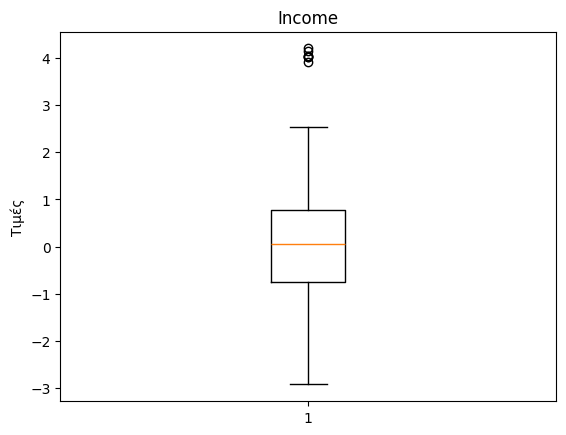

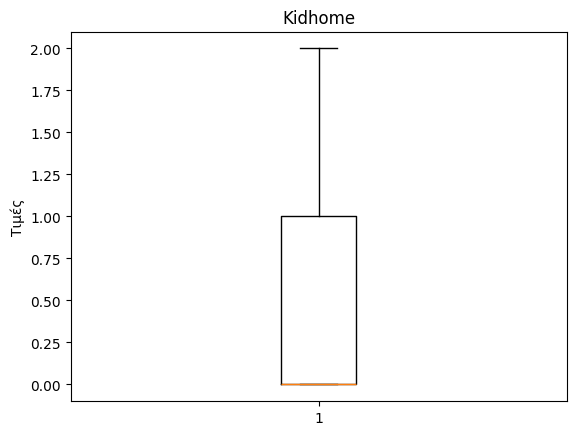

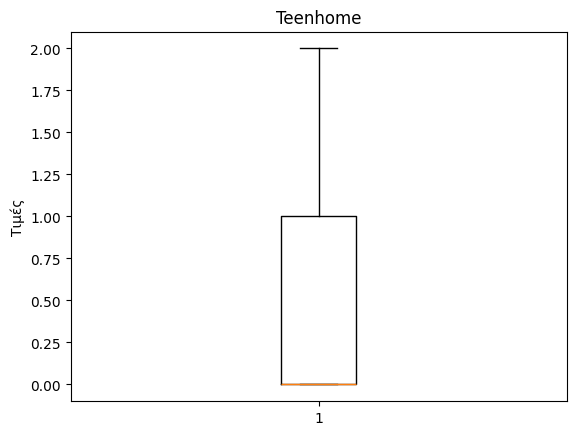

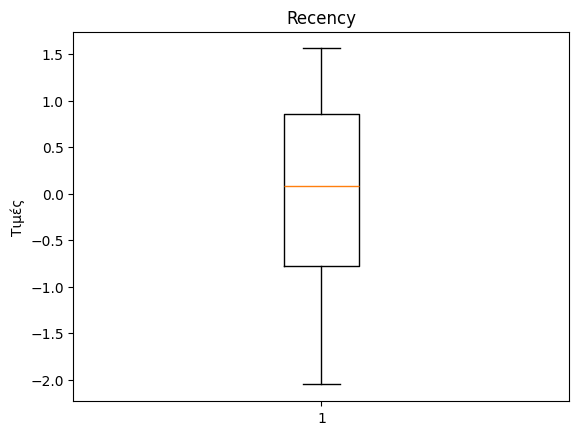

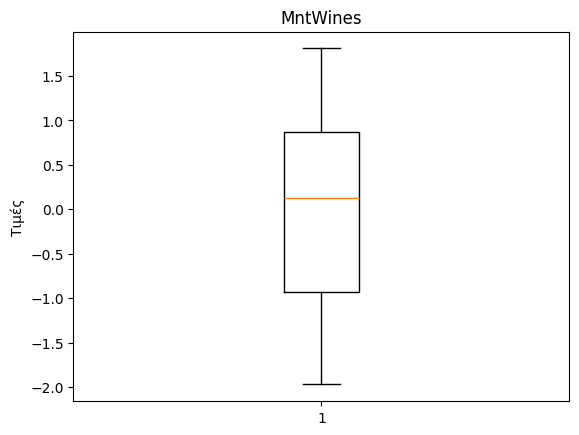

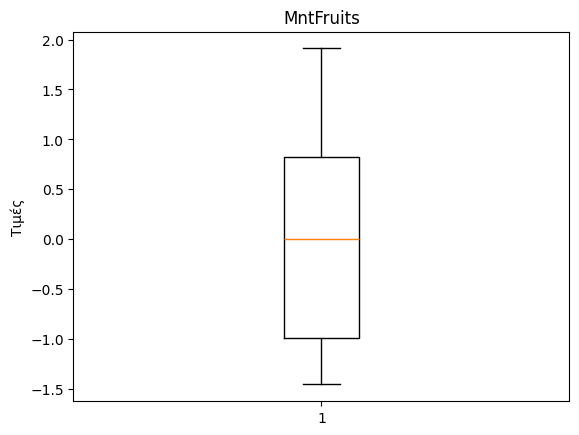

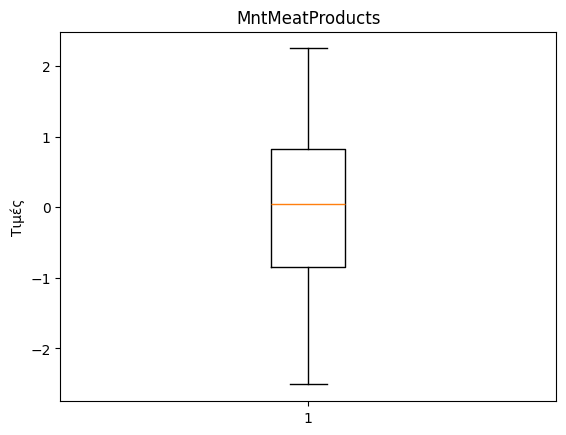

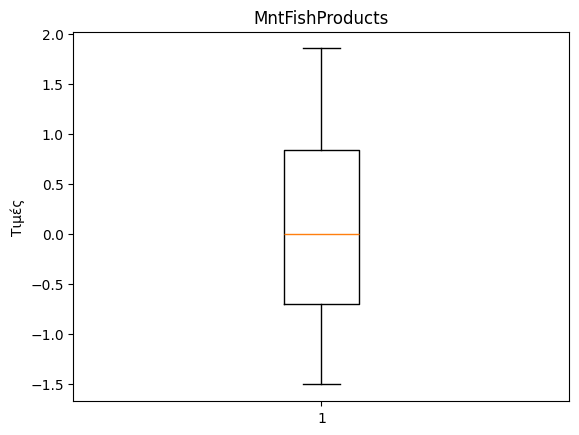

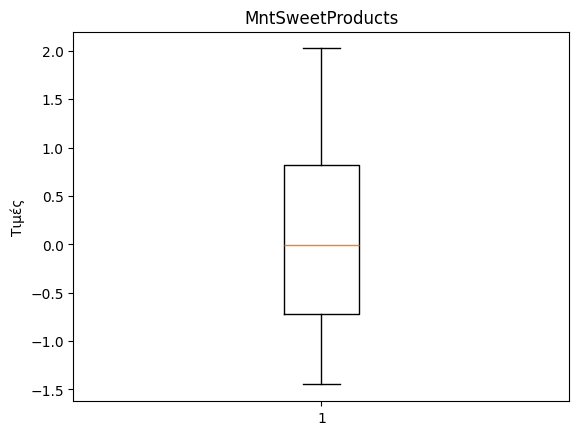

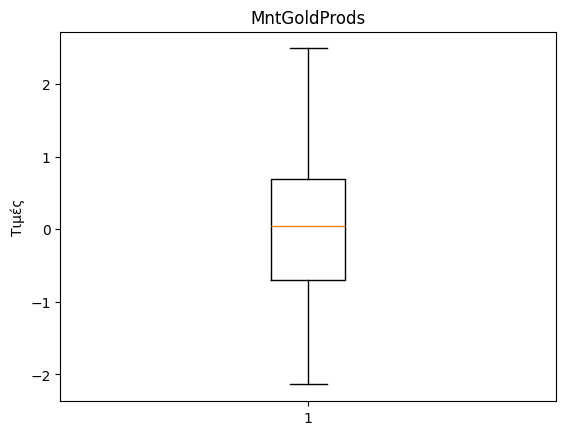

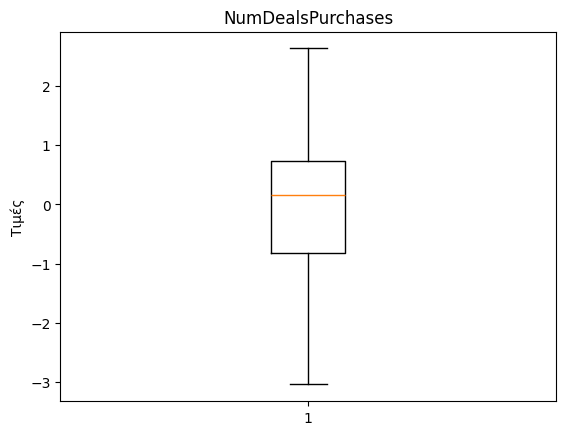

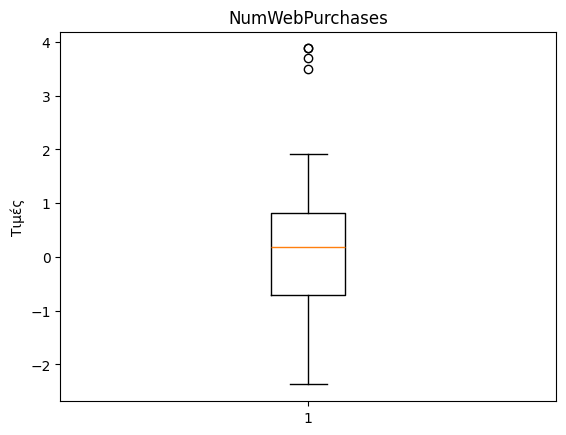

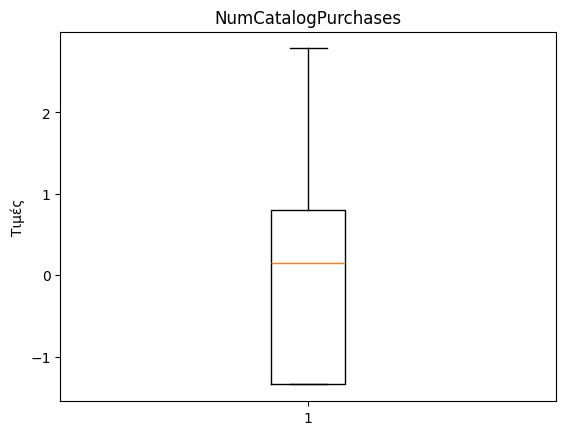

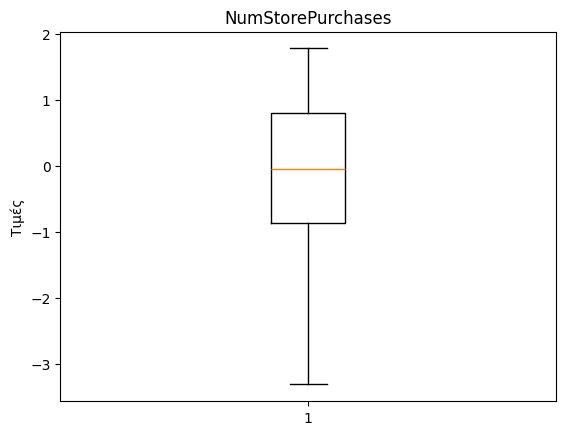

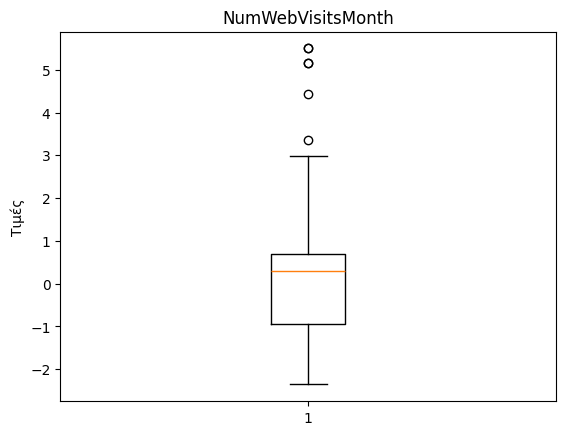

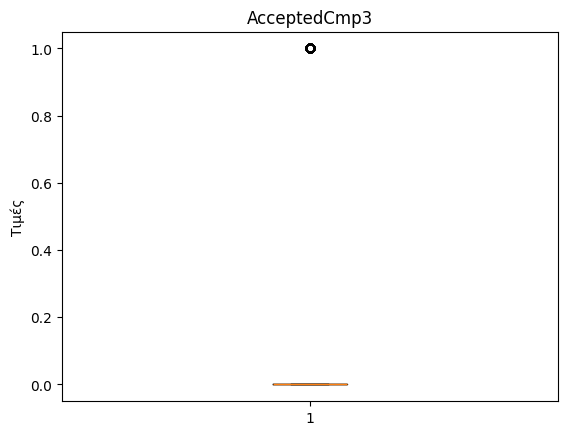

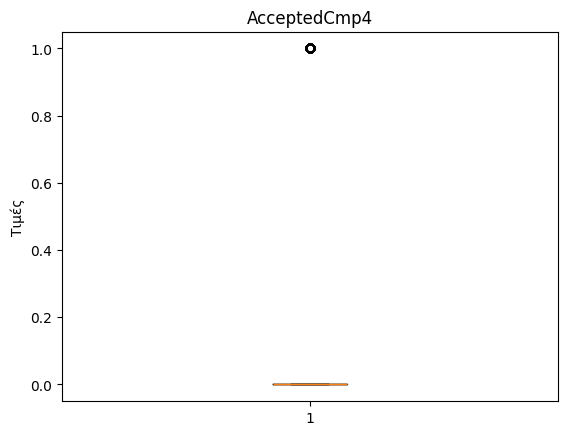

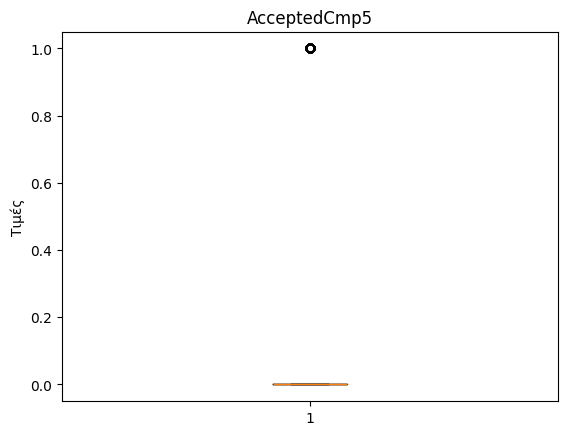

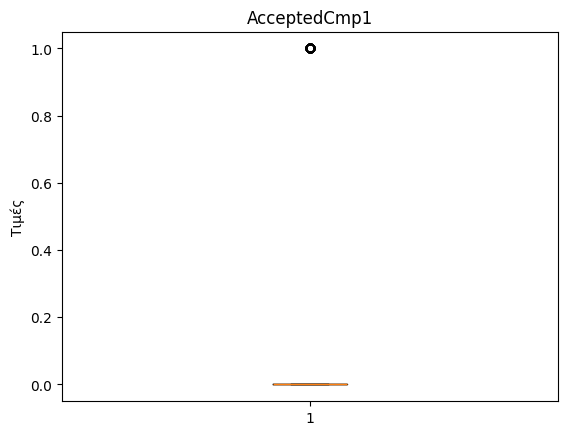

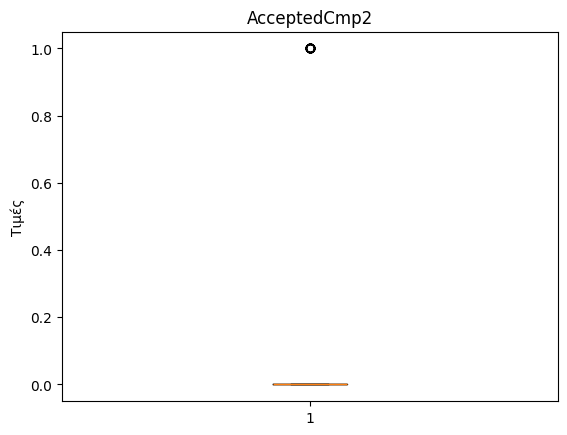

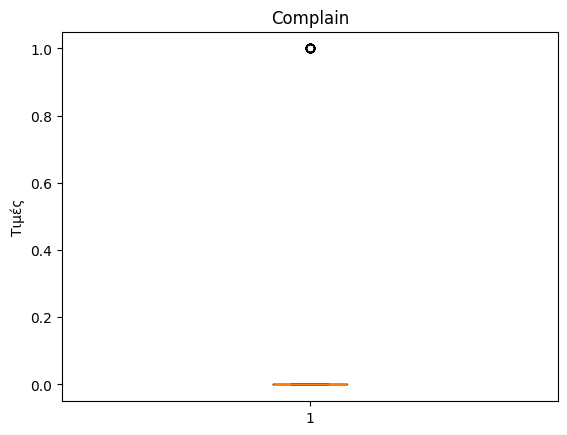

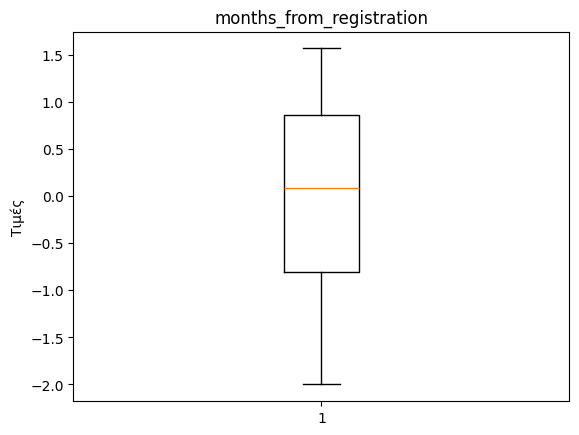

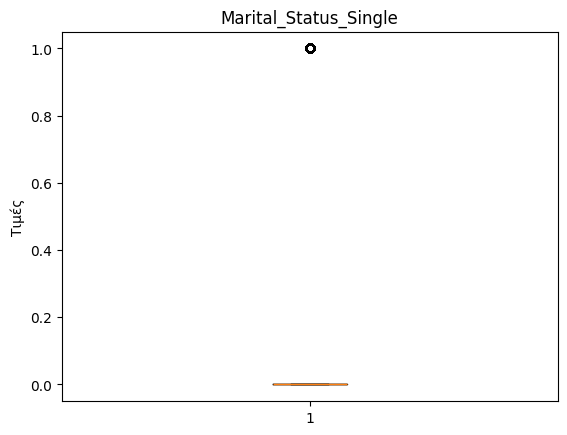

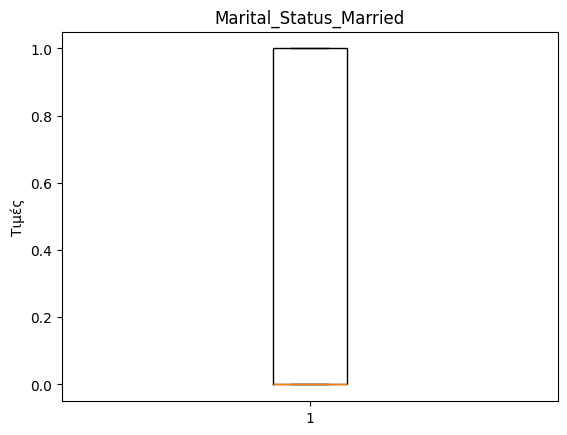

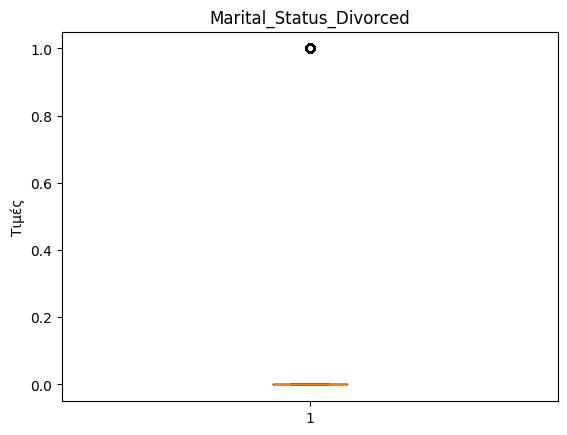

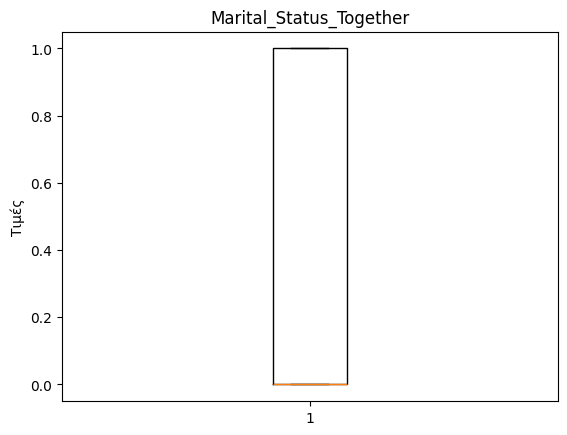

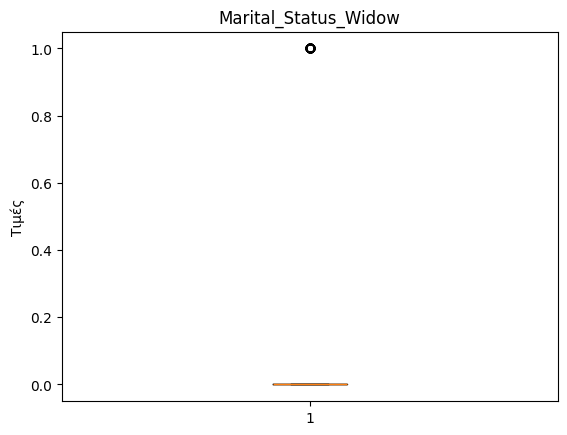

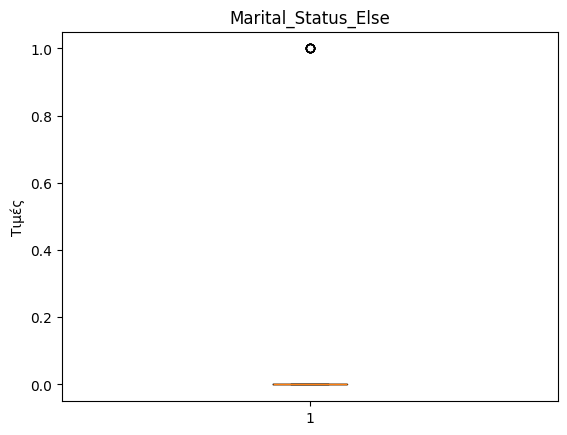

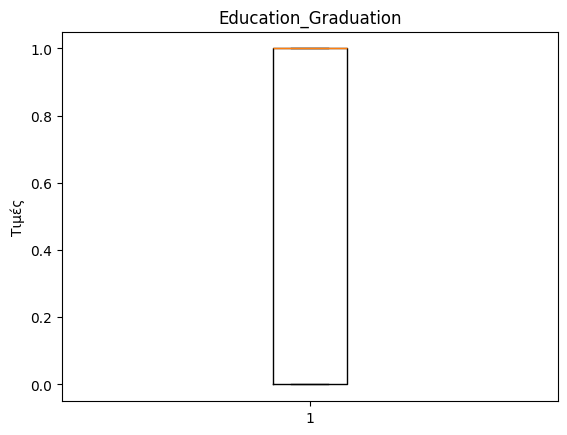

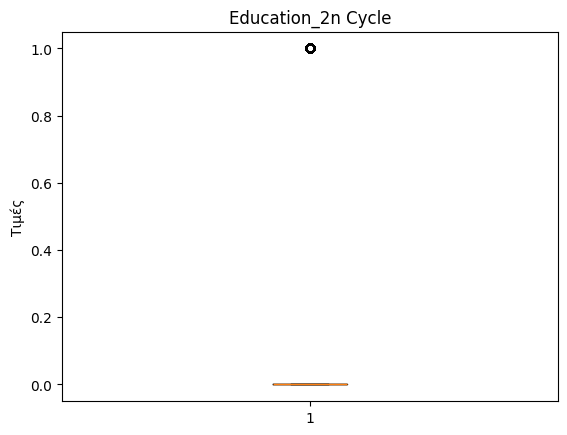

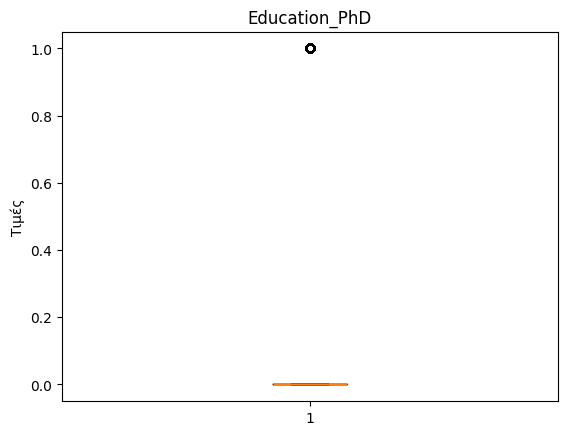

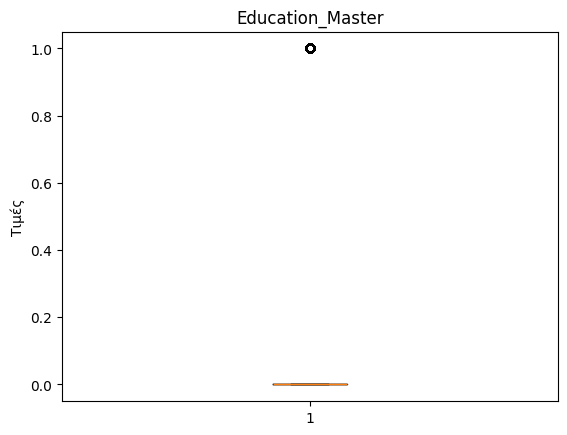

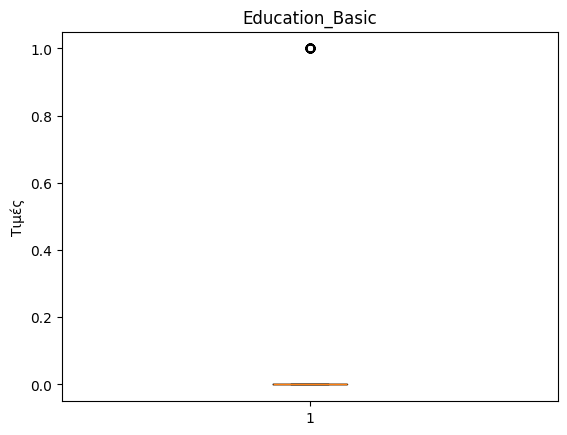

In [120]:
import matplotlib.pyplot as plt



df3 = X_train_V_4
all_features = df3.columns

for feat in all_features:
    plt.figure()
    plt.boxplot(df3[feat].dropna())
    plt.title(feat)
    plt.ylabel('Τιμές')
    plt.show()


In [121]:
# @title Dataset v14


In [122]:
X_train_V_14 = X_train_V_3_1.copy()
X_test_V_14 = X_test_V_3_1.copy()

In [123]:
transformer = PowerTransformer(method='yeo-johnson',standardize=True)#Standardize
features_to_scale = ['NumDealsPurchases'
,'MntMeatProducts','MntFishProducts','MntGoldProds','NumCatalogPurchases'
,'NumWebPurchases','MntWines', 'MntFruits', 'MntSweetProducts', 'Income']


X_train_V_14[features_to_scale] = transformer.fit_transform(X_train_V_14[features_to_scale])  # Fit and transform training data (Age and Fare columns only)
X_test_V_14[features_to_scale] = transformer.transform(X_test_V_14[features_to_scale])  # Transform test data


In [124]:
# 4. Δημιουργία του scaler
scaler = StandardScaler()
features_to_scale = ['NumStorePurchases','NumWebVisitsMonth','Recency']#education

# 5. Fit μόνο στο train set
scaler.fit(X_train_V_14[features_to_scale])


X_train_V_14[features_to_scale] = scaler.transform(X_train_V_14[features_to_scale])  # Fit and transform training data
X_test_V_14[features_to_scale] = scaler.transform(X_test_V_14[features_to_scale])  # Transform test data



In [125]:
scaler01 = MinMaxScaler(feature_range=(0,1))
X_train_V_14[['months_from_registration']] = scaler01.fit_transform(X_train_V_14[['months_from_registration']])
X_test_V_14[['months_from_registration']] = scaler01.transform(X_test_V_14[['months_from_registration']])

In [126]:
# @title Dataset v15


In [127]:
X_train_V_15 = X_train_V_3_1.copy()##### TO 3_1 CPPY INE TO KALO
X_test_V_15 = X_test_V_3_1.copy()

In [128]:
transformer = PowerTransformer(method='yeo-johnson')
features_to_scale = ['NumDealsPurchases'
,'MntMeatProducts','MntFishProducts','MntGoldProds','NumCatalogPurchases'
,'NumWebPurchases','MntWines', 'MntFruits', 'MntSweetProducts','NumWebVisitsMonth']


X_train_V_15[features_to_scale] = transformer.fit_transform(X_train_V_15[features_to_scale])  # Fit and transform training data
X_test_V_15[features_to_scale] = transformer.transform(X_test_V_15[features_to_scale])  # Transform test data


In [129]:
#Robust
rs = RobustScaler()
features_to_scale = ['NumWebPurchases','NumWebVisitsMonth', 'Income']#['MntWines', 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts','NumWebVisitsMonth', 'Income']#,'NumDealsPurchases'#
rs.fit(X_train_V_15[features_to_scale])
X_train_V_15[features_to_scale] = rs.transform(X_train_V_15[features_to_scale])
X_test_V_15[features_to_scale] = rs.transform(X_test_V_15[features_to_scale])

In [130]:
# 4. Δημιουργία του scaler
scaler = StandardScaler()
features_to_scale = ['NumStorePurchases','Recency']#education#'NumWebVisitsMonth'#Income

# 5. Fit μόνο στο train set
scaler.fit(X_train_V_15[features_to_scale])


X_train_V_15[features_to_scale] = scaler.transform(X_train_V_15[features_to_scale])  # Fit and transform training data
X_test_V_15[features_to_scale] = scaler.transform(X_test_V_15[features_to_scale])  # Transform test data



In [131]:
scaler01 = MinMaxScaler(feature_range=(0,1))
X_train_V_15[['months_from_registration']] = scaler01.fit_transform(X_train_V_15[['months_from_registration']])
X_test_V_15[['months_from_registration']] = scaler01.transform(X_test_V_15[['months_from_registration']])

In [132]:
print(X_train_V_15.describe())

            Income      Kidhome     Teenhome      Recency      MntWines  \
count  1788.000000  1788.000000  1788.000000  1788.000000  1.788000e+03   
mean      0.009855     0.441275     0.512864     0.000000 -1.900046e-16   
std       0.653873     0.537791     0.549051     1.000280  1.000280e+00   
min      -1.491761     0.000000     0.000000    -1.716208 -1.970541e+00   
25%      -0.498871     0.000000     0.000000    -0.846557 -9.294719e-01   
50%       0.000000     0.000000     0.000000    -0.011693  1.293934e-01   
75%       0.501129     1.000000     1.000000     0.857958  8.729208e-01   
max       3.357633     2.000000     2.000000     1.727609  1.809333e+00   

          MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
count  1.788000e+03     1.788000e+03     1.788000e+03      1.788000e+03   
mean  -6.755720e-17     1.192186e-17     9.636835e-17     -1.261730e-16   
std    1.000280e+00     1.000280e+00     1.000280e+00      1.000280e+00   
min   -1.455025e+00    -

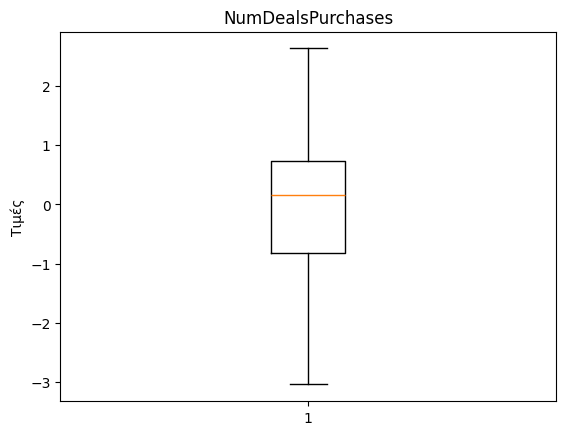

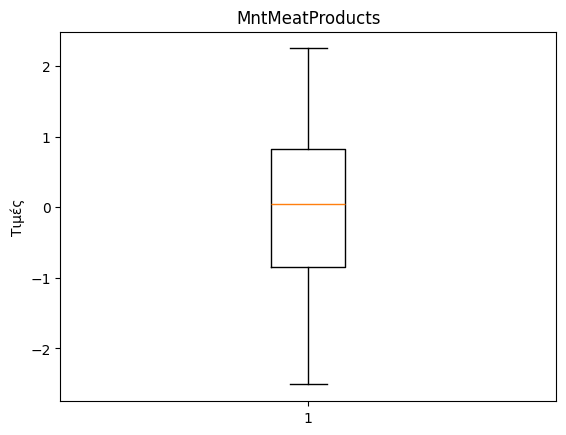

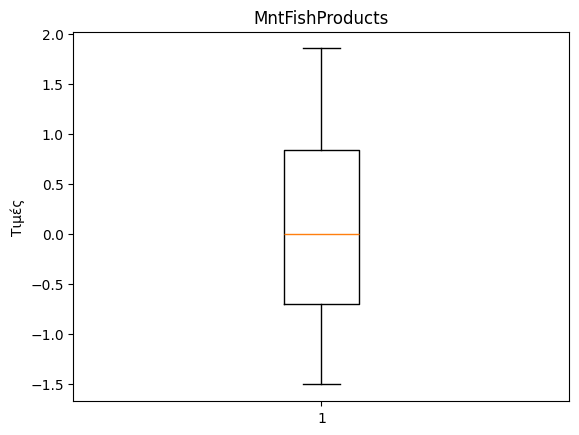

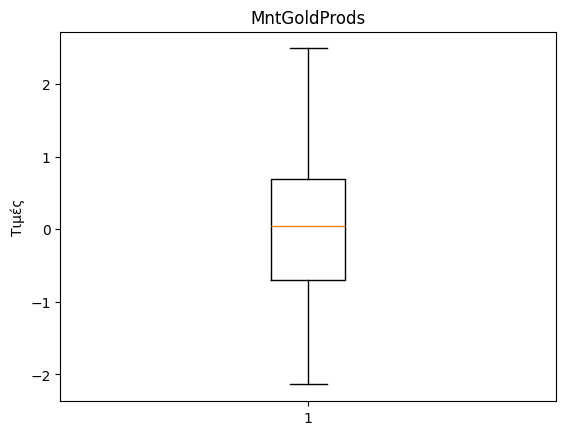

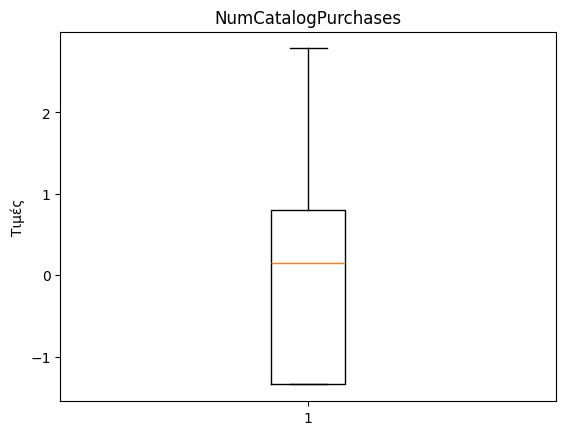

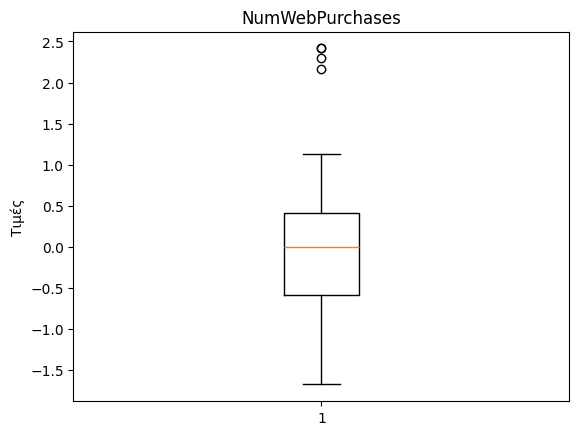

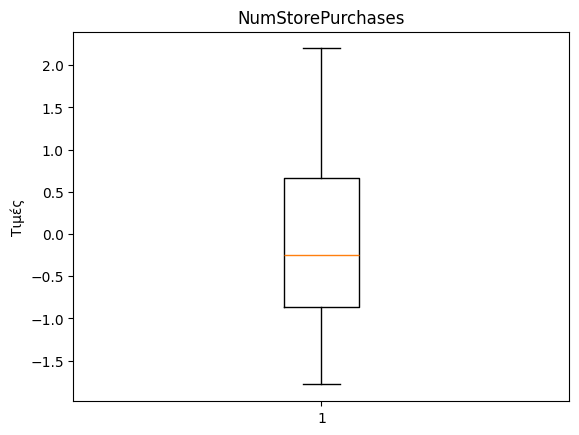

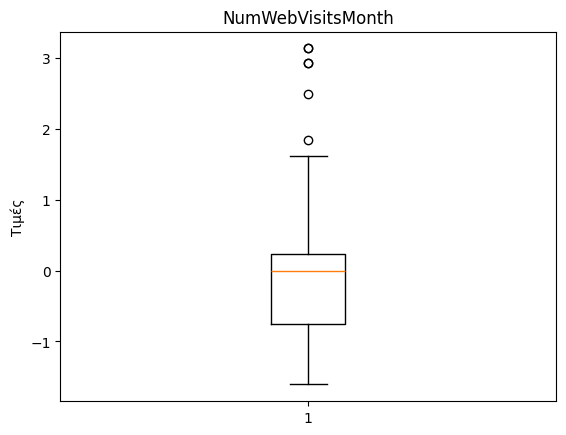

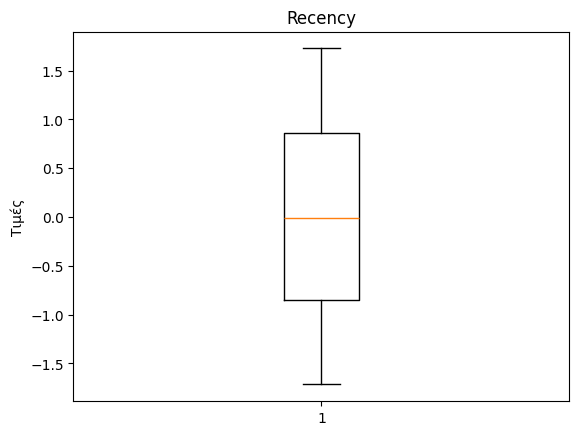

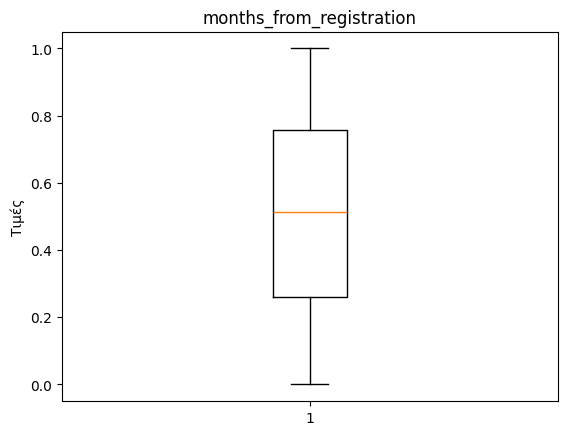

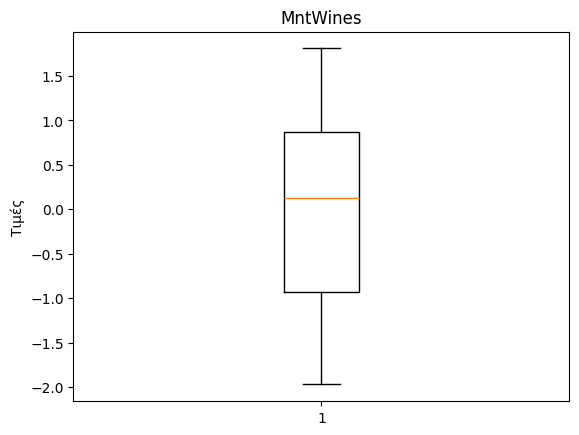

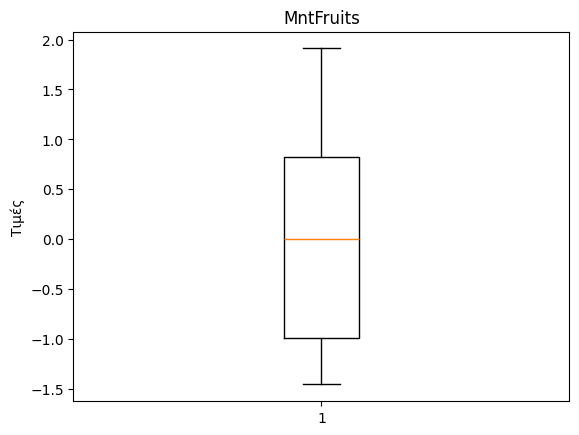

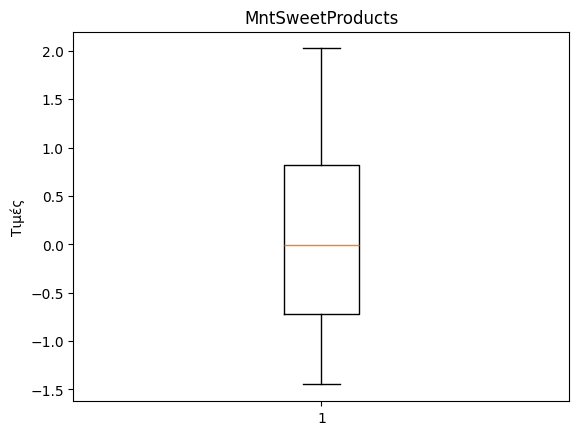

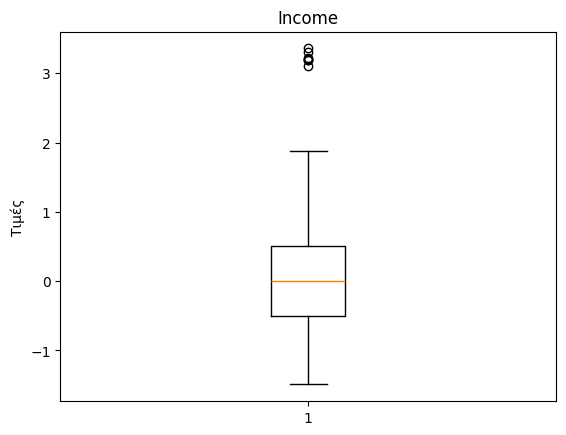

In [133]:
import matplotlib.pyplot as plt

features = [
    'NumDealsPurchases', 'MntMeatProducts', 'MntFishProducts', 'MntGoldProds',
    'NumCatalogPurchases', 'NumWebPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
    'Recency', 'months_from_registration', 'MntWines', 'MntFruits',
    'MntSweetProducts', 'Income'
]

df2 = X_train_V_15

for feat in features:
    plt.figure()
    plt.boxplot(df2[feat].dropna())
    plt.title(feat)
    plt.ylabel('Τιμές')
    plt.show()

In [134]:
for col in df2.columns:
    print(f"--- {col} ---")
    print(df2[col].describe())
    print()

--- Income ---
count    1788.000000
mean        0.009855
std         0.653873
min        -1.491761
25%        -0.498871
50%         0.000000
75%         0.501129
max         3.357633
Name: Income, dtype: float64

--- Kidhome ---
count    1788.000000
mean        0.441275
std         0.537791
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: Kidhome, dtype: float64

--- Teenhome ---
count    1788.000000
mean        0.512864
std         0.549051
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: Teenhome, dtype: float64

--- Recency ---
count    1788.000000
mean        0.000000
std         1.000280
min        -1.716208
25%        -0.846557
50%        -0.011693
75%         0.857958
max         1.727609
Name: Recency, dtype: float64

--- MntWines ---
count    1.788000e+03
mean    -1.900046e-16
std      1.000280e+00
min     -1.970541e+00
25%     -9.294719e-01
50%      1.29

In [135]:
# @title Dataset v16


In [136]:
X_train_V_16 = X_train_V_3_1.copy()##### TO 3_1 CPPY INE TO KALO
X_test_V_16 = X_test_V_3_1.copy()

In [137]:
transformer = PowerTransformer(method='yeo-johnson')
features_to_scale = ['NumDealsPurchases'
,'MntMeatProducts','MntFishProducts','MntGoldProds','NumCatalogPurchases'
,'NumWebPurchases','MntWines', 'MntFruits', 'MntSweetProducts']


X_train_V_16[features_to_scale] = transformer.fit_transform(X_train_V_16[features_to_scale])  # Fit and transform training data
X_test_V_16[features_to_scale] = transformer.transform(X_test_V_16[features_to_scale])  # Transform test data


In [138]:
#Robust
rs = RobustScaler()
features_to_scale = ['MntWines', 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts']#,'NumDealsPurchases'
rs.fit(X_train_V_16[features_to_scale])
X_train_V_16[features_to_scale] = rs.transform(X_train_V_16[features_to_scale])
X_test_V_16[features_to_scale] = rs.transform(X_test_V_16[features_to_scale])

In [139]:
# 4. Δημιουργία του scaler
scaler = StandardScaler()
features_to_scale = ['NumStorePurchases','NumWebVisitsMonth','Recency', 'Income','months_from_registration']#education

# 5. Fit μόνο στο train set
scaler.fit(X_train_V_16[features_to_scale])


X_train_V_16[features_to_scale] = scaler.transform(X_train_V_16[features_to_scale])  # Fit and transform training data
X_test_V_16[features_to_scale] = scaler.transform(X_test_V_16[features_to_scale])  # Transform test data



In [140]:
# @title Dataset v17


In [141]:
X_train_V_17 = X_train_V_15.copy()
X_test_V_17 = X_test_V_15.copy()

In [142]:
featuresets = {
   'v1': X_train_V_1 ,
   'v2': X_train_V_2 ,
   'v3': X_train_V_3 ,
   'v4': X_train_V_4 ,
   'v4.1': X_train_V_4_1 ,
  'v5': X_train_V_5 ,
  'v5.1': X_train_V_5_1 ,
    'v6': X_train_V_6,
   'v7': X_train_V_7,
 'v8': X_train_V_8,
   'v8.1': X_train_V_8_1,
   'v9': X_train_V_9,
   'v10': X_train_V_10,
   'v11': X_train_V_11,
   'v12': X_train_V_12,
    'v13': X_train_V_13,
   'v14': X_train_V_14,
   'v15': X_train_V_15,
   'v16': X_train_V_16
}


# Define classifiers
classifiers = {
    "RandomForest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(algorithm='SAMME'),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier(silent=True),
    "SVC": SVC(),
    "KNeighbors": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(),
    "DecisionTree": DecisionTreeClassifier(),
    "GaussianNB": GaussianNB()
}

# Dictionary to store results
results = []

f1_score_weighted = make_scorer(f1_score, average='weighted')

# Loop over each featureset version
for featureset, X_data in featuresets.items():
    # Loop over each classifier
    print(featureset+":", end=' ... ')
    for clf_name, clf in classifiers.items():
        print(clf_name, end=' ... ')
        # Perform 10-fold cross-validation , no validation set need
        scores = cross_val_score(clf, X_data, y_train, cv=10, scoring=f1_score_weighted, n_jobs=-1)
        # Store the average score for this classifier and dataset version
        avg_score = scores.mean()
        results.append({
            'featureset': featureset,
            'classifier': clf_name,
            'score': avg_score
        })
    print()

v1: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVC ... KNeighbors ... LogisticRegression ... DecisionTree ... GaussianNB ... 
v2: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVC ... KNeighbors ... LogisticRegression ... DecisionTree ... GaussianNB ... 
v3: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVC ... KNeighbors ... LogisticRegression ... DecisionTree ... GaussianNB ... 
v4: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVC ... KNeighbors ... LogisticRegression ... DecisionTree ... GaussianNB ... 
v4.1: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVC ... KNeighbors ... LogisticRegression ... DecisionTree ... GaussianNB ... 
v5: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVC ... KNeighbors ... LogisticRegression ... DecisionTree ... GaussianNB ... 
v5.1: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVC ... KNeighbors ... LogisticRegression ... DecisionTree ... GaussianNB ... 
v6

In [143]:
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)
results_df
# 1) Φιλτράρισμα
lr_results = results_df[results_df['classifier'] == 'LogisticRegression']

# 2) Εκτύπωση όλων των versions και των scores
print(lr_results)

    featureset          classifier     score
6           v1  LogisticRegression  0.827780
15          v2  LogisticRegression  0.826974
24          v3  LogisticRegression  0.822048
33          v4  LogisticRegression  0.888781
42        v4.1  LogisticRegression  0.885933
51          v5  LogisticRegression  0.885419
60        v5.1  LogisticRegression  0.883303
69          v6  LogisticRegression  0.885950
78          v7  LogisticRegression  0.883889
87          v8  LogisticRegression  0.888898
96        v8.1  LogisticRegression  0.888828
105         v9  LogisticRegression  0.888168
114        v10  LogisticRegression  0.885986
123        v11  LogisticRegression  0.889293
132        v12  LogisticRegression  0.889293
141        v13  LogisticRegression  0.889293
150        v14  LogisticRegression  0.889602
159        v15  LogisticRegression  0.889602
168        v16  LogisticRegression  0.889325


In [144]:
# Best performing classifiers: SVC, AdaBoostClssifier
results_df.groupby(['classifier'])['score'].agg(['mean']).sort_values(by='mean', ascending=False)

,mean
classifier,
CatBoost,0.885471
XGBoost,0.880349
AdaBoost,0.878774
LogisticRegression,0.877809
RandomForest,0.864472
SVC,0.851352
DecisionTree,0.831241
KNeighbors,0.829526
GaussianNB,0.810015


In [145]:
# Best performing featureset versions: v1, v2
results_df.groupby(['featureset'])['score'].agg(['mean']).sort_values(by='mean', ascending=False)

,mean
featureset,
v16,0.862640
v13,0.861509
v11,0.861152
v8.1,0.861061
v4,0.860900
v12,0.860762
v15,0.860409
v14,0.860174
v5.1,0.859884


In [146]:
# @title APROACH B

In [147]:

print(list(set(num_features) - set(features_to_scale)))
print(cat_features)
features_to_scale_V_4 = ['NumDealsPurchases'
,'MntMeatProducts','MntFishProducts','MntGoldProds','NumCatalogPurchases'
,'NumWebPurchases','NumStorePurchases','NumWebVisitsMonth','Recency','months_from_registration','MntWines', 'MntFruits','MntSweetProducts', 'Income']
#features_to_scale_V_15_yj = ['NumDealsPurchases'
#,'MntMeatProducts','MntFishProducts','MntGoldProds','NumCatalogPurchases'
#,'NumWebPurchases','MntWines', 'MntFruits', 'MntSweetProducts']
#features_to_scale_V_15_rs = ['MntWines', 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts']
#features_to_scale_V_15_ss = ['NumStorePurchases','NumWebVisitsMonth','Recency', 'Income']#education
#features_to_scale_V_15_mm = ['months_from_registration']

features_to_scale_yj = ['NumDealsPurchases'
,'MntMeatProducts','MntFishProducts','MntGoldProds','NumCatalogPurchases'
,'NumWebPurchases','MntWines', 'MntFruits', 'MntSweetProducts','NumWebVisitsMonth']


features_to_scale_rs = ['NumWebPurchases','NumWebVisitsMonth', 'Income']

features_to_scale_ss = ['NumStorePurchases','Recency']#education#'NumWebVisitsMonth'#Income






['Kidhome', 'Complain', 'AcceptedCmp5', 'AcceptedCmp1', 'MntSweetProducts', 'MntFruits', 'AcceptedCmp2', 'MntFishProducts', 'NumCatalogPurchases', 'MntGoldProds', 'NumDealsPurchases', 'MntWines', 'AcceptedCmp4', 'NumWebPurchases', 'AcceptedCmp3', 'Teenhome', 'MntMeatProducts']
Index(['Education', 'Marital_Status'], dtype='object')


In [148]:
from catboost import CatBoostClassifier

num_pipeline0 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])

num_pipeline1 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('unskewer', PowerTransformer(method='yeo-johnson'))#standardize=True
])

num_pipeline2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# 1) Pipeline με StandardScaler
num_pipeline3 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 3) Pipeline για κατηγορηματικά (OneHot Encoding)
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# preprocessing pipeline for creating featureset v4
preprocessor1 = ColumnTransformer(
    transformers=[
        ('num1', num_pipeline1, features_to_scale_V_4),                                 # numerical features to be scaled
        ('cat', cat_pipeline, cat_features)
    ],
    remainder='passthrough'
)
# preprocessing pipeline for creating featureset v15
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num1', num_pipeline1, features_to_scale_yj),      # numerical features to be unskewed
        ('num2', num_pipeline2, features_to_scale_rs),      # numerical features to be unskewed
        ('num3', num_pipeline3, features_to_scale_ss),      # numerical features to be unskewed
        ('cat', cat_pipeline, cat_features)
    ],
    remainder='passthrough'
)
# IMPORTANT NOTICE: avoid using multiple consecutive column transformers since they alter column order

#X_transformed = preprocessor2.fit_transform(X_train)
#f = pd.DataFrame(X_transformed, columns = X_train.columns)
#print(f.head(3))

# Create 4 pipelines with different preprocessing steps
pipeline1 = Pipeline([
    ('preprocessor', preprocessor1),
    ('classifier', LogisticRegression())
])
pipeline2 = Pipeline([
    ('preprocessor', preprocessor1),
    ('classifier', CatBoostClassifier(verbose=0))
])
pipeline3 = Pipeline([
    ('preprocessor', preprocessor2),
    ('classifier', LogisticRegression())
])
pipeline4 = Pipeline([
    ('preprocessor', preprocessor2),
    ('classifier', CatBoostClassifier(verbose=0))
])
#pipeline5 = Pipeline([
#    ('preprocessor', preprocessor3),
#    ('classifier', CatBoostClassifier(verbose=0))
#])

# Define different pipelines with different classifiers and preprocessing steps
pipelines = {
    'LogisticRegression_v1_pipeline': pipeline1,
    'CatBoost_v1_pipeline': pipeline2,
    'LogisticRegression_v2_pipeline': pipeline3,
    'CatBoost_v2_pipeline': pipeline4
 #       'CatBoost_v3_pipeline': pipeline5
}

# Set up parameter grid for GridSearchCV to explore both pipelines
# 1) Grid για LogisticRegression

param_grid_logistic = [
    {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l2', 'l1'],               # τύποι regularization
        'classifier__solver': ['liblinear', 'saga'],       # solvers που υποστηρίζουν τις παραπάνω ποινές :contentReference[oaicite:0]{index=0}
        'classifier__class_weight': [None, 'balanced'],     # για imbalanced datasets
        'classifier__max_iter':  [200, 500, 1000]#####

    }
]



# 1) Επαυξημένο Grid για LogisticRegression

# 2) Επαυξημένο Grid για CatBoostClassifier
#param_grid_catboost = [
#    {
#      'classifier__iterations': [50, 100, 200, 500, 1000, 2000],
#        'classifier__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 1.0],
#        'classifier__depth': [3, 4, 6, 8, 10],
#        'classifier__l2_leaf_reg': [1, 3, 5, 7, 9, 11]
#    }
#]


# 2) Grid για CatBoostClassifier

param_grid_catboost = [
    {
        'classifier__iterations': [100, 200, 500],         # αριθμός δέντρων/boosting rounds
        'classifier__learning_rate': [0.01, 0.1, 0.5],     # βήμα ενημέρωσης των weights
        'classifier__depth': [4, 6, 8],                    # μέγιστο βάθος δέντρου
        'classifier__l2_leaf_reg': [3, 5, 7]               # L2 regularization στο φύλλο :contentReference[oaicite:1]{index=1}
    }
]

param_grids = {
    'LogisticRegression_v1_pipeline': param_grid_logistic,
    'CatBoost_v1_pipeline': param_grid_catboost,
    'LogisticRegression_v2_pipeline': param_grid_logistic,
    'CatBoost_v2_pipeline': param_grid_catboost,
    'CatBoost_v3_pipeline': param_grid_catboost

}

# Loop through each pipeline and perform GridSearchCV
best_estimators = {}
for pipeline_name, pipeline in pipelines.items():
    print(f"Running GridSearchCV for {pipeline_name}...")
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grids[pipeline_name], cv=5, scoring=f1_score_weighted, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Store the best estimator and results for each pipeline
    best_estimators[pipeline_name] = grid_search.best_estimator_
    print(f"Best Parameters for {pipeline_name}: {grid_search.best_params_}")
    print(f"Best Cross-Validated Score for {pipeline_name}: {grid_search.best_score_}")

    # Make predictions using the best estimator
    y_pred = grid_search.best_estimator_.predict(X_test)  # Use X_test for evaluation
    print(f"Performance on the test dataset: {f1_score(y_test, y_pred, average='weighted')}") # Evaluate on the test dataset
    print("")

Running GridSearchCV for LogisticRegression_v1_pipeline...
Best Parameters for LogisticRegression_v1_pipeline: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__max_iter': 200, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Cross-Validated Score for LogisticRegression_v1_pipeline: 0.8908769211513606
Performance on the test dataset: 0.8714633580705009

Running GridSearchCV for CatBoost_v1_pipeline...
Best Parameters for CatBoost_v1_pipeline: {'classifier__depth': 4, 'classifier__iterations': 500, 'classifier__l2_leaf_reg': 7, 'classifier__learning_rate': 0.5}
Best Cross-Validated Score for CatBoost_v1_pipeline: 0.8955109425338181
Performance on the test dataset: 0.858344768375723

Running GridSearchCV for LogisticRegression_v2_pipeline...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Parameters for LogisticRegression_v2_pipeline: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__max_iter': 200, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best Cross-Validated Score for LogisticRegression_v2_pipeline: 0.8898454389209659
Performance on the test dataset: 0.8695653584995634

Running GridSearchCV for CatBoost_v2_pipeline...
Best Parameters for CatBoost_v2_pipeline: {'classifier__depth': 4, 'classifier__iterations': 200, 'classifier__l2_leaf_reg': 5, 'classifier__learning_rate': 0.5}
Best Cross-Validated Score for CatBoost_v2_pipeline: 0.8926876483644719
Performance on the test dataset: 0.8648563750821604



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Sequential Backward Selection (k=5):
Selected features: (2, 3, 4, 6, 10, 13, 15, 17, 18, 19, 21, 23, 25, 30)
Prediction (CV) score: 0.8980999503349573


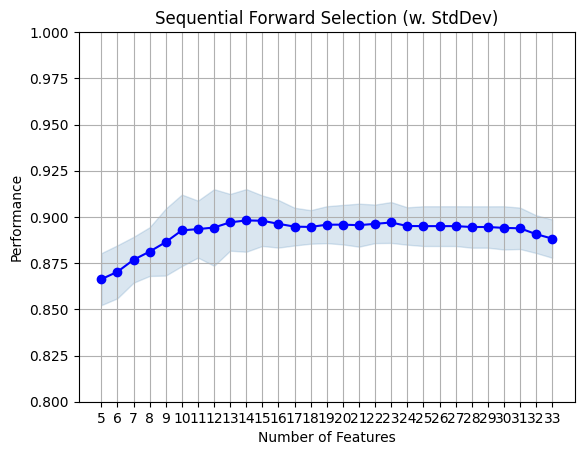

F1 score on training dataset: 0.8970771614905017
F1 score on training dataset: 0.8608956776342495


In [149]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
# Create the best model (using the best hyper-parameter values obtained frm the previous step)
#best_model = CatBoostClassifier(depth=4, iterations = 200,l2_leaf_reg = 3,learning_rate = 0.1)
best_model = LogisticRegression(C= 10, class_weight= None, max_iter= 500,penalty= 'l1', solver='saga')
# train the model on the dataset that achieves the highest score

sbs = SFS(best_model, # scikit-learn classifier
 k_features=(5, X_train_V_15.shape[1]-5), # termination criterion
 forward=False, # backward elimination
 floating=False,
 scoring='f1_weighted', # criterion function
 cv=5, # 10-fold cross validation
 n_jobs=-1)

sbs = sbs.fit(X_train_V_15, y_train)
print('\nSequential Backward Selection (k=5):')
print('Selected features:',sbs.k_feature_idx_)
print('Prediction (CV) score:',sbs.k_score_)
fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()


X_train_V_15 = sbs.transform(X_train_V_15)
X_test_V_15  = sbs.transform(X_test_V_15)

best_model.fit(X_train_V_15, y_train)


# make prediction on the train dataset in order to check for overfitting
# (overfitting arises when high performance on training dataset and low performance on test dataset => model does not generalize
y_train_pred = best_model.predict(X_train_V_15)
print("F1 score on training dataset:", f1_score(y_train, y_train_pred, average='weighted'))

# make prediction on the test dataset
y_test_pred = best_model.predict(X_test_V_15)
print("F1 score on training dataset:", f1_score(y_test, y_test_pred, average='weighted'))


Sequential Backward Selection (k=5):
Selected features: (0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31)
Prediction (CV) score: 0.8969431642922571


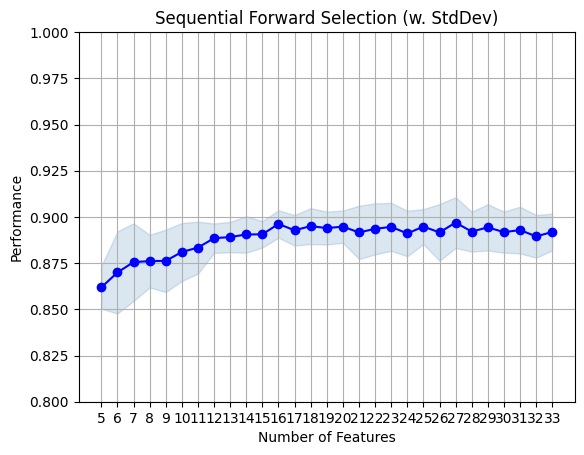

X_train_V_15 shape: (1788, 27)
X_test_V_15  shape: (448, 27)
y_train     shape: (1788,)
y_test      shape: (448,)
F1 score on training dataset: 0.9932561505950905
F1 score on training dataset: 0.8592284021461568


In [150]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
import catboost
from catboost import CatBoostClassifier
# Create the best model (using the best hyper-parameter values obtained frm the previous step)
best_model = CatBoostClassifier(depth=4, iterations = 500,l2_leaf_reg = 7,learning_rate = 0.5,verbose=0)
#best_model = LogisticRegression(C= 1, class_weight= None, max_iter= 200,penalty= 'l2', solver='liblinear')
# train the model on the dataset that achieves the highest score

sbs = SFS(best_model, # scikit-learn classifier
 k_features=(5, X_train_V_4.shape[1]), # termination criterion
 forward=False, # backward elimination
 floating=False,
 scoring='f1_weighted', # criterion function
 cv=5, # 10-fold cross validation
 n_jobs=-1)
sbs = sbs.fit(X_train_V_4, y_train)
print('\nSequential Backward Selection (k=5):')
print('Selected features:',sbs.k_feature_idx_)# (0, 2, 8, 9, 12)
print('Prediction (CV) score:',sbs.k_score_) # 0.9607843137254901
fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()




X_train_V_4 = sbs.transform(X_train_V_4)
X_test_V_4  = sbs.transform(X_test_V_4)

best_model.fit(X_train_V_4, y_train)







# make prediction on the train dataset in order to check for overfitting
# (overfitting arises when high performance on training dataset and low performance on test dataset => model does not generalize
y_train_pred = best_model.predict(X_train_V_4)
print("F1 score on training dataset:", f1_score(y_train, y_train_pred, average='weighted'))

# make prediction on the test dataset
y_test_pred = best_model.predict(X_test_V_4)
print("F1 score on training dataset:", f1_score(y_test, y_test_pred, average='weighted'))